In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageOps
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from torch import nn, optim
from torchvision import transforms
from torch import autograd
import torch.nn.functional as F
import os, os.path
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torchinfo import summary
from torchsummary import summary
from torchvision import models
from sklearn.preprocessing import OneHotEncoder
import re
import itertools
import functools
import operator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
dataset = 1 # LH agg = 1, LH plan = 2, LH gr = 3, LH col = 4, TH gr = 5, KA plan = 6, all data combined = 7
correlation = 2 # Holzer and Sommerfeld = 1, Mola = 2, No correlation, pure Cd prediction = 3
custom_loss = 1 # 1 = True, 2 = False. Custom loss turned off when correlation = 3
pretrained = 1 # 1 = True, 2 = False. Turned off when correlation = 3
rstate = 1 #random 5 kfold splits. Any integer; the same integer will always yield the same splits

In [3]:
## Set directory for images and data
dir_LH = '/Users/Crazz/Research Codes/LH_dataset.csv'
# dir_TH = 
# dir_KA =
dir_LHim = '/Users/Crazz/Research Codes/256res_LH'
# dir_KAim =
# dir_KAim =

## Set directory for desired pre-trained model to load in
dir_premodel = '/Users/Crazz/Research Codes/WORKING MODELS/Mola models/aggmola5model.pth'
## Set directory and name for saving model. Will overwrite a file of the same name
dir_model = '/Users/Crazz/Research Codes/WORKING MODELS/LHagg_HS_model_k' #split num 0-4 and file ext .pth automatically added 

In [ ]:
## LOAD ALL DATASETS
LH_newdf = pd.read_csv(dir_LH)
ids = []
for i in range(len(LH_newdf)):
    picnum = str(LH_newdf['Pic Number'][i])
    rollnum = str(LH_newdf['Roll Number'][i])
    if len(picnum) == 1:
        picnum = '0' + picnum
    if len(rollnum) == 1:
        rollnum = '0' + rollnum
    ids.append(rollnum + '_' + picnum + '.png')
LH_newdf['id'] = ids
LH_newdf = LH_newdf[LH_newdf['Cd']<13]
imgs = {}
path = dir_LHim
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    temp = Image.open(os.path.join(path,f))
    imgs[f] = temp.copy()
    temp.close()

img_df = pd.DataFrame(imgs.items(), columns=['id', 'images'])
LH_newdf = LH_newdf.merge(img_df, how='inner', on='id')
LH_newdf['t_Re'] = np.log(LH_newdf['Re'])
LH_newdf['t_Cd'] = np.log(LH_newdf['Cd'])
LH_agg = LH_newdf[LH_newdf['aggregate']==1].reset_index(drop=True)
LH_agg['tmp_idx'] = range(len(LH_agg))
LH_plan = LH_newdf[LH_newdf['planar_crystal']==1].reset_index(drop=True)
LH_plan['tmp_idx'] = range(len(LH_plan))
LH_gr = LH_newdf[LH_newdf['graupel']==1].reset_index(drop=True)
LH_gr['tmp_idx'] = range(len(LH_gr))
LH_col = LH_newdf[LH_newdf['columnar_crystal']==1].reset_index(drop=True)
LH_col['tmp_idx'] = range(len(LH_col))
LH_comb = LH_newdf[LH_newdf['combo']==1].reset_index(drop=True)             #NONE
LH_comb['tmp_idx'] = range(len(LH_comb))

Theis_df = pd.read_csv(dir_TH)
imgs = {}
path = dir_THim
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    temp = Image.open(os.path.join(path,f))
    imgs[f] = temp.copy()
    temp.close()

img_df = pd.DataFrame(imgs.items(), columns=['id', 'images'])
Theis_df = Theis_df.merge(img_df, how='inner', on='id')
Theis_df = Theis_df.rename(columns={'CHA':'area','Dmax':'diam','Mass':'mass','Vel':'vel'})
Theis_df['t_Re'] = np.log(Theis_df['Re'])
Theis_df['t_Cd'] = np.log(Theis_df['Cd'])
Theis_df['tmp_idx'] = np.arange(0,len(Theis_df),1) 

KA_df = pd.read_csv(dir_KA)
imgs = {}
path = dir_KAim
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    temp = Image.open(os.path.join(path,f))
    imgs[f] = temp.copy()
    temp.close()

img_df = pd.DataFrame(imgs.items(), columns=['id', 'images'])
KA_df = KA_df.merge(img_df, how='inner', on='id')
KA_df['t_Re'] = np.log(KA_df['Re'])
KA_df['t_Cd'] = np.log(KA_df['Cd'])
KA_df['tmp_idx'] = range(len(KA_df))

alldat = pd.concat([KA_df,LH_newdf,Theis_df]).reset_index(drop=True)
alldat['t_Re'] = np.log(alldat['Re'])
alldat['t_Cd'] = np.log(alldat['Cd'])
alldat['tmp_idx'] = range(len(alldat))

In [4]:
import shutil
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir / 'checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir / 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']
                                                                                                                                                                                                                               

class regloader(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X['images']
        self.label = X['tmp_idx']
        self.A_char = X['area']
        self.Re = X['t_Re']
        self.Cd = X['t_Cd']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = (self.X[idx])
        label = torch.tensor(self.label[idx])
        A_char = torch.tensor(self.A_char[idx], dtype=torch.float32)
        Re = torch.tensor(self.Re[idx], dtype=torch.float32)
        Cd = torch.tensor(self.Cd[idx], dtype=torch.float32)
        
        transform = transforms.Compose([
            transforms.RandomInvert(0.5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]) # might need to change
        # seperate ys
        return label,transform(X),A_char,Re,Cd
    
class KGCNN1(nn.Module):
    def __init__(self):
        super(KGCNN1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),#, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 64, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 80, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.geom = nn.Sequential(
            nn.Linear(80 * 14 * 14, 50), # 48*12*12 if size is 256, *4*4 128
            nn.ReLU(True),
            nn.Dropout(0.15),
            nn.Linear(50, 7), # 7 geoms return
            nn.Softplus(),
        )
    def forward(self, image):
        top_out = self.conv(image)
        middle = top_out.view(top_out.size(0), -1)
        geoms_out = self.geom(middle)
        #print(image.size())
        #print(middle1.size())
        #print(data.size())
        return geoms_out
    
class KGCNN2(nn.Module):
    def __init__(self):
        super(KGCNN2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),#, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 64, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 80, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.geom = nn.Sequential(
            nn.Linear(80 * 14 * 14, 50), # 48*12*12 if size is 256, *4*4 128
            nn.ReLU(True),
            nn.Dropout(0.15),
            nn.Linear(50, 8), # 8 geoms return
            nn.Softplus(),
        )
    def forward(self, image):
        top_out = self.conv(image)
        middle = top_out.view(top_out.size(0), -1)
        geoms_out = self.geom(middle)
        #print(image.size())
        #print(middle1.size())
        #print(data.size())
        return geoms_out
class KGCNN3(nn.Module):
    def __init__(self):
        super(KGCNN3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),#, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 64, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 80, 3),# stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.geom = nn.Sequential(
            nn.Linear(80 * 14 * 14+1, 50), # 48*12*12 if size is 256, *4*4 128
            nn.ReLU(True),
            nn.Dropout(0.15),
            nn.Linear(50, 1), # 7 geoms return
        )
    def forward(self, image,Re):
        top_out = self.conv(image)
        middle = top_out.view(top_out.size(0), -1)
        middle_cd = torch.cat((middle, Re),dim=1)
        Cd_out = self.geom(middle_cd)
        
        #print(image.size())
        #print(middle1.size())
        #print(data.size())
        return Cd_out
    
# Custom physics loss
def physics_loss(sar, sph, length_sph, cross_sph, A_crat, A_lrat):
    tiny = 0.000000001
    loss_c = (sph/(4*sar) - A_crat*cross_sph)**2
    loss_l = (sph/(4*sar) - length_sph*(1/(2*sar) - A_lrat))**2
    loss_c = torch.mean(loss_c)
    loss_l = torch.mean(loss_l)
    # penalize geom outputs if outside range
    if torch.max(porosity)>=1:
        loss_por = 100*(porosity-0.9)**2
    else:
        loss_por = torch.tensor(0.000000001, requires_grad=True)
    if torch.max(sar) >= 0.5:
        loss_sar = 100*(sar-0.4)**2
    else:
        loss_sar = torch.tensor(0.000000001, requires_grad=True)
    if torch.max(sph) >= 1:
        loss_sph = 100*(sph-0.9)**2
    else:
        loss_sph = torch.tensor(0.000000001, requires_grad=True)
    loss_pg = torch.mean(loss_c + loss_l + loss_por + loss_sar + loss_sph)
    return loss_c, loss_l, loss_pg

## Holzer and Sommerfeld correlation
def HnS(Re,sph,lsph,csph):
    Cd_HS = 8/(Re*torch.sqrt(lsph)) + 16/(Re*torch.sqrt(sph)) + 3/(torch.sqrt(Re)*sph**(3/4)) + (1/csph)*0.4210**(0.4*((-torch.log(sph))**0.2))
    return Cd_HS
## Mola et al. correlation
def Mola(Re,por,sph,lsph,csph,Df):
    a1 = 0.10861
    a2 = 0.28273
    a3 = 0.21479
    a4 = 0.65317
    a5 = 1.49629
    b1 = 8.48137
    b2 = 5.07235
    b3 = 0.44850
    b4 = -0.71
    b5 = -1.89037
    c1 = 0.66886
    c2 = 0.14686
    c3 = -0.84224
    c4 = 0.02821
    c5 = -3.54344
    lam1 = 8*(a1*por+a2)*(a3*sph+a4)*Df**a5
    lam2 = 16*(b1*por+b2)*(b3*sph+b4)*Df**b5
    lam3 = c1*(por**((c2*(1-por)/por)**c3))*(Re**c4)*sph**c5
    Cd_M = lam1/(Re*torch.sqrt(csph)) + lam2/(Re*torch.sqrt(sph)) + lam3*(3/(torch.sqrt(Re)*sph**(3/4)) + (1/csph)*0.4210**(0.4*((-torch.log(sph))**0.2)))
    return Cd_M

if dataset == 1: # LH agg
    k_folds = 5
    batch_size = 2
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-6
    num_epochs = 750
    fulldata = regloader(LH_agg)
    cur_df = LH_agg
if dataset == 2: # LH plan
    k_folds = 5
    batch_size = 2
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-6
    num_epochs = 750
    fulldata = regloader(LH_plan)
    cur_df = LH_plan
if dataset == 3: # LH graupel
    k_folds = 5
    batch_size = 6
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-5
    num_epochs = 750
    fulldata = regloader(LH_gr)
    cur_df = LH_gr
if dataset == 4: # LH col
    k_folds = 5
    batch_size = 2
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-6
    num_epochs = 750
    fulldata = regloader(LH_col)
    cur_df = LH_col
if dataset == 5: # TH graupel
    k_folds = 5
    batch_size = 2
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-6
    num_epochs = 750
    fulldata = regloader(Theis_df)
    cur_df = Theis_df
if dataset == 6: # KA planar
    k_folds = 5
    batch_size = 2
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-6
    num_epochs = 750
    fulldata = regloader(KA_df)
    cur_df = KA_df
if dataset == 7: # all data combined
    k_folds = 5
    batch_size = 10
    kf = KFold(n_splits=k_folds, shuffle=True,random_state=rstate)
    lr = 1e-5
    num_epochs = 750
    fulldata = regloader(alldata)
    cur_df = alldata

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if correlation == 1
    model = KGCNN1.to(device)
if correlation == 2
    model = KGCNN2.to(device)
if correlation == 3
    model = KGCNN3.to(device)


criterion = nn.MSELoss() #MSELoss()  # Mean squared error loss #L1Loss()


# Training loop
if correlation == 1:
    train_Cd_curves = []
    train_pg_curves = []

    test_Cd_curves = []
    test_pg_curves = []

    goodplanmodel_epoch = np.array([0,0,0,0,0])

    best_test_acc = np.array([100,100,100,100,100])
    for fold, (train_ids, test_ids) in enumerate(kf.split(fulldata)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_ids),
        )
        test_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_ids),
        )
        model = KGCNN1.to(device)
        non_frozen_parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(non_frozen_parameters, lr=lr)  # Choose an optimizer
        if pretrained == 1:
            model, optimizer, start_epoch = load_ckp(dir_premodel, model, optimizer)

        best_test = best_test_acc[fold]
        train_llist_Cd = []
        train_llist_pg = []

        test_llist_Cd = []
        test_llist_pg = []

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode

            train_Cd_loss = 0.0
            train_pg_loss = 0.0

            for id,images,A_char,Re,Cd in train_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                geoms_out = model(images)
                sph = geoms_out[:,0]
                cross_sph = geoms_out[:,1]
                length_sph = geoms_out[:,2]
                porosity = geoms_out[:,3]
                sar = geoms_out[:,4]
                A_crat = geoms_out[:,5]
                A_lrat = geoms_out[:,6]

                sph = sph.view(Re.size(0),1)
                cross_sph = cross_sph.view(Re.size(0),1)
                length_sph = length_sph.view(Re.size(0),1)
                porosity = porosity.view(Re.size(0),1)
                sar = sar.view(Re.size(0),1)
                A_crat = A_crat.view(A_crat.size(0),1)
                A_lrat = A_lrat.view(A_lrat.size(0),1)

                loss_c,loss_l,loss_pg = physics_loss(sar*0.5,sph,length_sph*2,cross_sph*3.5,A_crat*1.5,A_lrat*1.5)

                Cd_act = HnS(torch.exp(Re),sph,length_sph*2,cross_sph*3.5)#*(torch.abs(1 - porosity))**0.17)*torch.exp(Re)**-0.13)
                Cd_logout = torch.log(Cd_act)

                # TOTAL loss w/o phys Cd
                # sum physics guided and regular losses from Cd and geom parameters
                if torch.max(sph) >= 1:
                    loss_Cd = 2*torch.abs(torch.max(sph)-0.5)**2
                else:
                    loss_Cd = criterion(Cd_logout,Cd)
                loss_Cd = loss_Cd.to(device)
                loss_tot = loss_Cd + loss_pg

                # Backward pass and optimization
                if custom_loss == 1:
                    loss_tot.backward()
                if custom_loss == 2:
                    loss_Cd.backward()
                #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                clip_value = 10
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                optimizer.zero_grad()

                #####
                train_Cd_loss += loss_Cd * id.size(0)
                train_pg_loss += loss_pg * id.size(0)

            train_Cd_loss /= len(train_loader.dataset)
            train_pg_loss /= len(train_loader.dataset)

            train_llist_pg.append(train_pg_loss.item())

            # Evaluation
            model.eval()  # Set the model in evaluation mode

            test_Cd_loss = 0.0
            test_pg_loss = 0.0

            with torch.no_grad():
                for id,images,A_char,Re,Cd in test_loader:

                    id = id.to(device)
                    images = Variable(images, requires_grad=True)
                    A_char = Variable(A_char, requires_grad=True)
                    Re = Variable(Re, requires_grad=True)
                    Cd = Variable(Cd, requires_grad=True)

                    A_char = A_char.view(A_char.size(0),1)
                    Re = Re.view(Re.size(0),1)
                    Cd = Cd.view(Cd.size(0),1)

                    images = images.to(device)
                    A_char = A_char.to(device)
                    Re = Re.to(device)
                    Cd = Cd.to(device)

                    #with autograd.detect_anomaly():
                    # Forward pass
                    geoms_out = model(images)
                    sph = geoms_out[:,0]
                    cross_sph = geoms_out[:,1]
                    length_sph = geoms_out[:,2]
                    porosity = geoms_out[:,3]
                    sar = geoms_out[:,4]
                    A_crat = geoms_out[:,5]
                    A_lrat = geoms_out[:,6]

                    sph = sph.view(Re.size(0),1)
                    cross_sph = cross_sph.view(Re.size(0),1)
                    length_sph = length_sph.view(Re.size(0),1)
                    porosity = porosity.view(Re.size(0),1)
                    sar = sar.view(Re.size(0),1)
                    A_crat = A_crat.view(A_crat.size(0),1)
                    A_lrat = A_lrat.view(A_lrat.size(0),1)

                    loss_c,loss_l,loss_pg = physics_loss(sar*0.5,sph,length_sph*2,cross_sph*3.5,A_crat*1.5,A_lrat*1.5)

                    Cd_act = HnS(torch.exp(Re),sph,length_sph*2,cross_sph*3.5)#*(torch.abs(1 - porosity))**0.17)*torch.exp(Re)**-0.13)
                    Cd_logout = torch.log(Cd_act)

                    # TOTAL loss w/o phys Cd
                    # sum physics guided and regular losses from Cd and geom parameters
                    loss_Cd = criterion(Cd_logout,Cd)

                    loss_tot = loss_Cd + loss_pg
                    # TOTAL loss w/o phys Cd
                    # sum physics guided and regular losses from Cd and geom parameters
                    test_Cd_loss += loss_Cd * id.size(0)
                    test_pg_loss += loss_pg * id.size(0)

            test_Cd_loss /= len(test_loader.dataset)
            test_pg_loss /= len(test_loader.dataset)

            test_llist_Cd.append(test_Cd_loss.item())
            test_llist_pg.append(test_pg_loss.item())

            if test_Cd_loss < best_test:
                torch.save(model.state_dict(), dir_model+str(fold)+'.pth')
                goodplanmodel_epoch[fold] = epoch
                best_test = test_Cd_loss

            print(f"Epoch {epoch+1}/{num_epochs} - Train Cd Loss: {train_Cd_loss:.6f} - Test Loss: {test_Cd_loss:.6f}")
            print(f"Epoch {epoch+1}/{num_epochs} - Train pg Loss: {train_pg_loss:.6f} - Test Loss: {test_pg_loss:.6f}")
            print('\n')
            #print(Cd_out)
        train_Cd_curves.append(train_llist_Cd)
        test_Cd_curves.append(test_llist_Cd)
        train_pg_curves.append(train_llist_pg)
        test_pg_curves.append(test_llist_pg)

if correlation == 2:
    train_Cd_curves = []
    train_pg_curves = []

    test_Cd_curves = []
    test_pg_curves = []

    best_test_acc = np.array([100,100,100,100,100])

    # Training loop

    for fold, (train_ids, test_ids) in enumerate(kf.split(fulldata)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_ids),
        )
        test_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_ids),
        )
        model = KGCNN2.to(device)
        non_frozen_parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(non_frozen_parameters, lr=lr)  # Choose an optimizer
        
        if pretrained == 1:
            model, optimizer, start_epoch = load_ckp(dir_premodel, model, optimizer)
    
        best_test = best_test_acc[fold]

        train_llist_Cd = []
        train_llist_pg = []
        test_llist_Cd = []
        test_llist_pg = []

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode

            train_Cd_loss = 0.0
            train_Df_loss = 0.0
            train_pg_loss = 0.0

            for id,images,A_char,Re,Cd,Df_dat in train_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)
                Df_dat = Variable(Df_dat, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)
                Df_dat = Df_dat.view(Df_dat.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)
                Df_dat = Df_dat.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                geoms_out = model(images)
                sph = geoms_out[:,0]
                cross_sph = geoms_out[:,1]
                length_sph = geoms_out[:,2]
                porosity = geoms_out[:,3]
                sar = geoms_out[:,4]
                A_crat = geoms_out[:,5]
                A_lrat = geoms_out[:,6]
                Df = geoms_out[:,7]

                sph = sph.view(Re.size(0),1)
                cross_sph = cross_sph.view(Re.size(0),1)
                length_sph = length_sph.view(Re.size(0),1)
                porosity = porosity.view(Re.size(0),1)
                sar = sar.view(Re.size(0),1)
                A_crat = A_crat.view(A_crat.size(0),1)
                A_lrat = A_lrat.view(A_lrat.size(0),1)
                Df = Df.view(Df.size(0),1)

                loss_c,loss_l,loss_pg = physics_loss(sar*0.5,sph,length_sph*2,cross_sph*3.5,A_crat*1.5,A_lrat*1.5)

                Cd_act = Mola(torch.exp(Re),porosity,sph,length_sph*2,cross_sph*3.5,Df*3*1.3)
                Cd_logout = torch.log(Cd_act)

                # TOTAL loss w/o phys Cd
                # sum physics guided and regular losses from Cd and geom parameters
                if torch.max(sph) >= 1 or torch.max(porosity) >= 1:
                    loss_Cd = torch.tensor(0.2,requires_grad=True)
                elif torch.min(Cd_act) <= 0.0:
                    loss_Cd = torch.abs(torch.min(Cd_act)*50)
                else:
                    loss_Cd = criterion(Cd_logout,Cd)

                if torch.max(Df*3*1.3) >= 3:
                    loss_Df = torch.abs(torch.max(Df*3*1.3)-2.9)**2
                elif torch.min(Df*3*1.3) <= 1.4:
                    loss_Df = torch.abs(torch.min(Df*3*1.3)-1.5)**2
                else:
                    loss_Df = criterion(Df*3*1.3,Df_dat*3*1.3)/8

                loss_Df = loss_Df.to(device)
                loss_Cd = loss_Cd.to(device)
                loss_tot = loss_Cd + loss_Df + loss_pg

                # Backward pass and optimization
                if custom_loss == 1:
                    loss_tot.backward()
                if custom_loss == 2:
                    (loss_Cd+loss_Df).backward()
                
                #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                clip_value = 10
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                optimizer.zero_grad()

                #####
                train_Cd_loss += loss_Cd * id.size(0)
                train_Df_loss += loss_Df* id.size(0)
                train_pg_loss += loss_pg * id.size(0)

            train_Cd_loss /= len(train_loader.dataset)
            train_Df_loss /= len(train_loader.dataset)
            train_pg_loss /= len(train_loader.dataset)

            train_llist_pg.append(train_pg_loss.item())

            # Evaluation
            model.eval()  # Set the model in evaluation mode

            test_Cd_loss = 0.0
            test_Df_loss = 0.0
            test_pg_loss = 0.0

            with torch.no_grad():
                for id,images,A_char,Re,Cd,Df_dat in test_loader:

                    id = id.to(device)
                    images = Variable(images, requires_grad=True)
                    A_char = Variable(A_char, requires_grad=True)
                    Re = Variable(Re, requires_grad=True)
                    Cd = Variable(Cd, requires_grad=True)
                    Df_dat = Variable(Df_dat, requires_grad=True)

                    A_char = A_char.view(A_char.size(0),1)
                    Re = Re.view(Re.size(0),1)
                    Cd = Cd.view(Cd.size(0),1)
                    Df_dat = Df_dat.view(Df_dat.size(0),1)

                    images = images.to(device)
                    A_char = A_char.to(device)
                    Re = Re.to(device)
                    Cd = Cd.to(device)
                    Df_dat = Df_dat.to(device)

                    #with autograd.detect_anomaly():
                    # Forward pass
                    geoms_out = model(images)
                    sph = geoms_out[:,0]
                    cross_sph = geoms_out[:,1]
                    length_sph = geoms_out[:,2]
                    porosity = geoms_out[:,3]
                    sar = geoms_out[:,4]
                    A_crat = geoms_out[:,5]
                    A_lrat = geoms_out[:,6]
                    Df = geoms_out[:,7]

                    sph = sph.view(Re.size(0),1)
                    cross_sph = cross_sph.view(Re.size(0),1)
                    length_sph = length_sph.view(Re.size(0),1)
                    porosity = porosity.view(Re.size(0),1)
                    sar = sar.view(Re.size(0),1)
                    A_crat = A_crat.view(A_crat.size(0),1)
                    A_lrat = A_lrat.view(A_lrat.size(0),1)
                    Df = Df.view(Df.size(0),1)

                    loss_c,loss_l,loss_pg = physics_loss(sar*0.5,sph,length_sph*2,cross_sph*3.5,A_crat*1.5,A_lrat*1.5)

                    Cd_act = Mola(torch.exp(Re),porosity,sph,length_sph*2,cross_sph*3.5,Df*3*1.3)
                    Cd_logout = torch.log(Cd_act)

                    # TOTAL loss w/o phys Cd
                    # sum physics guided and regular losses from Cd and geom parameters
                    loss_Cd = criterion(Cd_logout,Cd)
                    loss_Df = criterion(Df*3*1.3,Df_dat*3*1.3)/8
                    loss_tot = loss_Cd + loss_Df + loss_pg
                    # TOTAL loss w/o phys Cd
                    # sum physics guided and regular losses from Cd and geom parameters
                    test_Cd_loss += loss_Cd * id.size(0)
                    test_Df_loss += loss_Df * id.size(0)
                    test_pg_loss += loss_pg * id.size(0)

            test_Cd_loss /= len(test_loader.dataset)
            test_Df_loss /= len(test_loader.dataset)
            test_pg_loss /= len(test_loader.dataset)

            test_llist_Cd.append(test_Cd_loss.item())
            test_llist_pg.append(test_pg_loss.item())

            if test_Cd_loss < best_test:
                torch.save(model.state_dict(), dir_model+str(fold)+'.pth')
                goodplanmodel_epoch = epoch
                best_test = test_Cd_loss

            print(f"Epoch {epoch+1}/{num_epochs} - Train Cd Loss: {train_Cd_loss:.6f} - Test Loss: {test_Cd_loss:.6f}")
            print(f"Epoch {epoch+1}/{num_epochs} - Train Df Loss: {train_Df_loss:.6f} - Test Loss: {test_Df_loss:.6f}")
            print(f"Epoch {epoch+1}/{num_epochs} - Train pg Loss: {train_pg_loss:.6f} - Test Loss: {test_pg_loss:.6f}")
            print('\n')
            #print(Cd_out)
        train_Cd_curves.append(train_llist_Cd)
        test_Cd_curves.append(test_llist_Cd)
        train_pg_curves.append(train_llist_pg)
        test_pg_curves.append(test_llist_pg)

if correlation == 3:
    train_llist_Cd = []
    test_llist_Cd = []
    goodplanmodel_epoch = np.array([0,0,0,0,0])

    best_test_acc = np.array([100,100,100,100,100])

    # Training loop

    for fold, (train_ids, test_ids) in enumerate(kf.split(fulldata)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_ids),
        )
        test_loader = DataLoader(
            dataset=fulldata,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_ids),
        )
        model = KGCNN3.to(device)
        non_frozen_parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(non_frozen_parameters, lr=lr)  # Choose an optimizer
        best_test = best_test_acc[fold]

        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode

            train_Cd_loss = 0.0

            for id,images,A_char,Re,Cd in train_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                cd_out = model(images,Re)

                loss_Cd = criterion(cd_out,Cd)

                # Backward pass and optimization
                loss_Cd.backward()
                #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                clip_value = 10
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                optimizer.zero_grad()

                #####
                train_Cd_loss += loss_Cd * id.size(0)

            train_Cd_loss /= len(train_loader.dataset)

            # Evaluation
            model.eval()  # Set the model in evaluation mode

            test_Cd_loss = 0.0

            with torch.no_grad():
                for id,images,A_char,Re,Cd in test_loader:

                    id = id.to(device)
                    images = Variable(images, requires_grad=True)
                    A_char = Variable(A_char, requires_grad=True)
                    Re = Variable(Re, requires_grad=True)
                    Cd = Variable(Cd, requires_grad=True)

                    A_char = A_char.view(A_char.size(0),1)
                    Re = Re.view(Re.size(0),1)
                    Cd = Cd.view(Cd.size(0),1)

                    images = images.to(device)
                    A_char = A_char.to(device)
                    Re = Re.to(device)
                    Cd = Cd.to(device)

                    #with autograd.detect_anomaly():
                    # Forward pass
                    cd_out = model(images,Re)

                    loss_Cd = criterion(cd_out,Cd)

                    # TOTAL loss w/o phys Cd
                    # sum physics guided and regular losses from Cd and geom parameters
                    test_Cd_loss += loss_Cd * id.size(0)

            test_Cd_loss /= len(test_loader.dataset)

            test_llist_Cd.append(test_Cd_loss.item())

            if test_Cd_loss < best_test:
                torch.save(model.state_dict(), dir_model+str(fold)+'.pth')
                goodplanmodel_epoch[fold] = epoch
                best_test = test_Cd_loss

            print(f"Epoch {epoch+1}/{num_epochs} - Train Cd Loss: {train_Cd_loss:.6f} - Test Loss: {test_Cd_loss:.6f}")
            print('\n')
print('Completed training.')
print('Now evaluating performance')

if correlation == 1:
    hs_planout = pd.DataFrame(columns=['por','sar','sph','lsph','csph','Acrat','Alrat','Cdout','massout','Rhos','Rhoc','Rhol','id','Cd','Re','mass'])
    x,y,z,w,v = kf.split(fulldata)
    model = KGCNN1.to(device)
    for i in range(5):
        model.load_state_dict(torch.load(dir_model+str(i)+".pth"))
        if i == 0:
            test_loader = DataLoader(
                dataset=fulldata,
                batch_size=1,
                sampler=torch.utils.data.SubsetRandomSampler(x[1])
            )
        elif i == 1:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(y[1])
            )
        elif i == 2:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(z[1])
            )
        elif i == 3:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(w[1])
            )
        elif i == 4:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(v[1])
            )
        model.eval()  # Set the model in evaluation mode

        Cd_outs = []
        por_outs = []
        sar_outs = []
        sph_outs = []
        csph_outs = []
        lsph_outs = []
        Acrat_outs = []
        Alrat_outs = []

        Cd_ans = []

        test_ids = []
        with torch.no_grad():
            for id,images,A_char,Re,Cd in test_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                geoms_out = model(images)
                sph = geoms_out[:,0]
                cross_sph = geoms_out[:,1]
                length_sph = geoms_out[:,2]
                porosity = geoms_out[:,3]
                sar = geoms_out[:,4]
                A_crat = geoms_out[:,5]
                A_lrat = geoms_out[:,6]

                sph = sph.view(Re.size(0),1)
                cross_sph = cross_sph.view(Re.size(0),1)
                length_sph = length_sph.view(Re.size(0),1)
                porosity = porosity.view(Re.size(0),1)
                sar = sar.view(Re.size(0),1)
                A_crat = A_crat.view(A_crat.size(0),1)
                A_lrat = A_lrat.view(A_lrat.size(0),1)

                Cd_out = HnS(torch.exp(Re),sph,length_sph*2,cross_sph*3.5)#*(torch.abs(1 - porosity))**0.17)*torch.exp(Re)**-0.13)
                Cd_logout = torch.log(Cd_out)

                Cd_outs.append(Cd_out.item())
                por_outs.append(porosity.item())
                sar_outs.append(sar.item())
                sph_outs.append(sph.item())
                lsph_outs.append(length_sph.item())
                csph_outs.append(cross_sph.item())
                Acrat_outs.append(A_crat.item())
                Alrat_outs.append(A_lrat.item())

                Cd_ans.append(torch.exp(Cd).item())

                test_ids.append(id.item())
                #err += (abs(outputs - t_Cd)/t_Cd)*100
                #print(err)
                #loss =  l + loss_mean
        #outs_act = np.array(outs)
        #answers_act = np.array(answers)
        Cd_outs = np.array(Cd_outs)
        Cd_acts = np.array(Cd_outs)

        por_outs = np.array(por_outs)
        sar_outs = np.array(sar_outs)
        sph_outs = np.array(sph_outs)
        lsph_outs = np.array(lsph_outs)
        csph_outs = np.array(csph_outs)
        Acrat_outs = np.array(Acrat_outs)
        Alrat_outs = np.array(Alrat_outs)
        por_outs = por_outs
        sar_outs = sar_outs*0.5
        sph_outs = sph_outs
        l_sph_outs = lsph_outs*2
        c_sph_outs = csph_outs*3.5
        Acrat_outs = Acrat_outs*1.5
        Alrat_outs = Alrat_outs*1.5

        Cd_ans = np.array(Cd_ans)
        Cd_actans = np.array(Cd_ans)

        test_ids = np.array(test_ids)
        mass_out = Cd_acts*0.5*cur_df['rho'][test_ids]*(cur_df['vel'][test_ids]**2)*cur_df['area'][test_ids]/9.81
        Cd_errs = ((Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_errs_abs = (abs(Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_aerrs = -((Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_aerrs_abs = (abs(Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_mse = (Cd_acts - Cd_actans)**2
        Cd_rmse = np.sqrt(np.sum(Cd_mse)/len(Cd_mse))
        Cd_nrmse = (Cd_rmse/np.mean(Cd_actans))*100
        mass_mse = (mass_out - cur_df['mass'][test_ids])**2
        mass_rmse = np.sqrt(np.sum(mass_mse)/len(mass_mse))
        mass_nrmse = (mass_rmse/2.644140625e-07)*100
        Vol_out_s = 4*np.pi/3*(sph_outs/(4*sar_outs) * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_s = mass_out/Vol_out_s
        Vol_out_c = 4*np.pi/3*(c_sph_outs*Acrat_outs * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_c = mass_out/Vol_out_c
        Vol_out_l = 4*np.pi/3*(l_sph_outs*(1/(2*sar_outs)-Alrat_outs) * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_l = mass_out/Vol_out_l
        predout = pd.DataFrame(por_outs,columns=['por'])
        predout['sar'] = sar_outs
        predout['sph'] = sph_outs
        predout['lsph'] = l_sph_outs
        predout['csph'] = c_sph_outs
        predout['Acrat'] = Acrat_outs
        predout['Alrat'] = Alrat_outs
        predout['Cdout'] = Cd_outs
        predout['massout'] = np.array(mass_out)
        predout['Rhos'] = np.array(rho_s)
        predout['Rhoc'] = np.array(rho_c)
        predout['Rhol'] = np.array(rho_l)
        predout['id'] = np.array(cur_df['id'][test_ids])
        predout['Cd'] = np.array(cur_df['Cd'][test_ids])
        predout['Re'] = np.array(cur_df['Re'][test_ids])
        predout['mass'] = np.array(cur_df['mass'][test_ids])
        hs_planout = pd.concat([hs_planout,predout],ignore_index=True)
        
if correlation == 2:
    hs_planout = pd.DataFrame(columns=['por','sar','sph','lsph','csph','Acrat','Alrat','Df_out','Cdout','massout','Rhos','Rhoc','Rhol','id','Cd','Re','Df','mass'])
    x,y,z,w,v = kf.split(fulldata)
    model = KGCNN2.to(device)
    for i in range(5):
        model.load_state_dict(torch.load(dir_model+str(i)+".pth"))
        if i == 0:
            test_loader = DataLoader(
                dataset=fulldata,
                batch_size=1,
                sampler=torch.utils.data.SubsetRandomSampler(x[1])
            )
        elif i == 1:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(y[1])
            )
        elif i == 2:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(z[1])
            )
        elif i == 3:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(w[1])
            )
        elif i == 4:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(v[1])
            )
        model.eval()  # Set the model in evaluation mode

        Cd_outs = []
        por_outs = []
        sar_outs = []
        sph_outs = []
        csph_outs = []
        lsph_outs = []
        Acrat_outs = []
        Alrat_outs = []
        Df_outs = []

        Cd_ans = []
        Df_ans = []

        test_ids = []
        with torch.no_grad():
            for id,images,A_char,Re,Cd,Df_dat in test_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)
                Df_dat = Variable(Df_dat, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)
                Df_dat = Df_dat.view(Df_dat.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)
                Df_dat = Df_dat.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                geoms_out = model(images)
                sph = geoms_out[:,0]
                cross_sph = geoms_out[:,1]
                length_sph = geoms_out[:,2]
                porosity = geoms_out[:,3]
                sar = geoms_out[:,4]
                A_crat = geoms_out[:,5]
                A_lrat = geoms_out[:,6]
                Df = geoms_out[:,7]

                sph = sph.view(Re.size(0),1)
                cross_sph = cross_sph.view(Re.size(0),1)
                length_sph = length_sph.view(Re.size(0),1)
                porosity = porosity.view(Re.size(0),1)
                sar = sar.view(Re.size(0),1)
                A_crat = A_crat.view(A_crat.size(0),1)
                A_lrat = A_lrat.view(A_lrat.size(0),1)
                Df = Df.view(Df.size(0),1)

                Cd_out = Mola(torch.exp(Re),porosity,sph,length_sph*2,cross_sph*3.5,Df*3*1.3)
                Cd_logout = torch.log(Cd_out)

                Cd_outs.append(Cd_out.item())
                por_outs.append(porosity.item())
                sar_outs.append(sar.item())
                sph_outs.append(sph.item())
                lsph_outs.append(length_sph.item())
                csph_outs.append(cross_sph.item())
                Acrat_outs.append(A_crat.item())
                Alrat_outs.append(A_lrat.item())
                Df_outs.append(Df.item())

                Cd_ans.append(torch.exp(Cd).item())
                Df_ans.append(Df_dat.item())

                test_ids.append(id.item())
                #err += (abs(outputs - t_Cd)/t_Cd)*100
                #print(err)
                #loss =  l + loss_mean
        #outs_act = np.array(outs)
        #answers_act = np.array(answers)
        Cd_outs = np.array(Cd_outs)
        Cd_acts = np.array(Cd_outs)

        por_outs = np.array(por_outs)
        sar_outs = np.array(sar_outs)
        sph_outs = np.array(sph_outs)
        lsph_outs = np.array(lsph_outs)
        csph_outs = np.array(csph_outs)
        Acrat_outs = np.array(Acrat_outs)
        Alrat_outs = np.array(Alrat_outs)
        Df_outs = np.array(Df_outs)
        por_outs = por_outs
        sar_outs = sar_outs*0.5
        sph_outs = sph_outs
        l_sph_outs = lsph_outs*2
        c_sph_outs = csph_outs*3.5
        Acrat_outs = Acrat_outs*1.5
        Alrat_outs = Alrat_outs*1.5
        Df_outs = Df_outs*3*1.3

        Cd_ans = np.array(Cd_ans)
        Cd_actans = np.array(Cd_ans)
        Df_ans = np.array(Df_ans)*3*1.3

        test_ids = np.array(test_ids)
        mass_out = Cd_acts*0.5*cur_df['rho'][test_ids]*(cur_df['vel'][test_ids]**2)*cur_df['area'][test_ids]/9.81
        Cd_errs = ((Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_errs_abs = (abs(Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_aerrs = -((Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_aerrs_abs = (abs(Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_mse = (Cd_acts - Cd_actans)**2
        Cd_rmse = np.sqrt(np.sum(Cd_mse)/len(Cd_mse))
        Cd_nrmse = (Cd_rmse/np.mean(Cd_actans))*100
        mass_mse = (mass_out - cur_df['mass'][test_ids])**2
        mass_rmse = np.sqrt(np.sum(mass_mse)/len(mass_mse))
        mass_nrmse = (mass_rmse/2.644140625e-07)*100
        Vol_out_s = 4*np.pi/3*(sph_outs/(4*sar_outs) * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_s = mass_out/Vol_out_s
        Vol_out_c = 4*np.pi/3*(c_sph_outs*Acrat_outs * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_c = mass_out/Vol_out_c
        Vol_out_l = 4*np.pi/3*(l_sph_outs*(1/(2*sar_outs)-Alrat_outs) * cur_df['area'][test_ids]/np.pi)**(3/2)
        rho_l = mass_out/Vol_out_l
        predout = pd.DataFrame(por_outs,columns=['por'])
        predout['sar'] = sar_outs
        predout['sph'] = sph_outs
        predout['lsph'] = l_sph_outs
        predout['csph'] = c_sph_outs
        predout['Acrat'] = Acrat_outs
        predout['Alrat'] = Alrat_outs
        predout['Df_out'] = Df_outs
        predout['Cdout'] = Cd_outs
        predout['massout'] = np.array(mass_out)
        predout['Rhos'] = np.array(rho_s)
        predout['Rhoc'] = np.array(rho_c)
        predout['Rhol'] = np.array(rho_l)
        predout['id'] = np.array(cur_df['id'][test_ids])
        predout['Cd'] = np.array(cur_df['Cd'][test_ids])
        predout['Re'] = np.array(cur_df['Re'][test_ids])
        predout['Df'] = Df_ans
        predout['mass'] = np.array(cur_df['mass'][test_ids])
        hs_planout = pd.concat([hs_planout,predout],ignore_index=True)

if correlation == 3:
    hs_planout = pd.DataFrame(columns=['Cdout','massout','id','Cd','Re','mass'])
    x,y,z,w,v = kf.split(fulldata)
    model = KGCNN3.to(device)
    for i in range(5):
        model.load_state_dict(torch.load(dir_model+str(i)+".pth"))
        if i == 0:
            test_loader = DataLoader(
                dataset=fulldata,
                batch_size=1,
                sampler=torch.utils.data.SubsetRandomSampler(x[1])
            )
        elif i == 1:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(y[1])
            )
        elif i == 2:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(z[1])
            )
        elif i == 3:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(w[1])
            )
        elif i == 4:
            test_loader = DataLoader(
            dataset=fulldata,
            batch_size=1,
            sampler=torch.utils.data.SubsetRandomSampler(v[1])
            )
        model.eval()  # Set the model in evaluation mode

        Cd_outs = []

        Cd_ans = []

        test_ids = []
        with torch.no_grad():
            for id,images,A_char,Re,Cd in test_loader:

                id = id.to(device)
                images = Variable(images, requires_grad=True)
                A_char = Variable(A_char, requires_grad=True)
                Re = Variable(Re, requires_grad=True)
                Cd = Variable(Cd, requires_grad=True)

                A_char = A_char.view(A_char.size(0),1)
                Re = Re.view(Re.size(0),1)
                Cd = Cd.view(Cd.size(0),1)

                images = images.to(device)
                A_char = A_char.to(device)
                Re = Re.to(device)
                Cd = Cd.to(device)

                #with autograd.detect_anomaly():
                # Forward pass
                cd_out = model(images,Re)

                Cd_outs.append(torch.exp(cd_out).item())

                Cd_ans.append(torch.exp(Cd).item())

                test_ids.append(id.item())
                #err += (abs(outputs - t_Cd)/t_Cd)*100
                #print(err)
                #loss =  l + loss_mean
        #outs_act = np.array(outs)
        #answers_act = np.array(answers)
        Cd_outs = np.array(Cd_outs)
        Cd_acts = np.array(Cd_outs)

        Cd_ans = np.array(Cd_ans)
        Cd_actans = np.array(Cd_ans)

        test_ids = np.array(test_ids)
        mass_out = Cd_acts*0.5*cur_df['rho'][test_ids]*(cur_df['vel'][test_ids]**2)*cur_df['area'][test_ids]/9.81
        Cd_errs = ((Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_errs_abs = (abs(Cd_ans - Cd_outs)/abs(Cd_ans))*100
        Cd_aerrs = -((Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_aerrs_abs = (abs(Cd_actans - Cd_acts)/abs(Cd_actans))*100
        Cd_mse = (Cd_acts - Cd_actans)**2
        Cd_rmse = np.sqrt(np.sum(Cd_mse)/len(Cd_mse))
        Cd_nrmse = (Cd_rmse/np.mean(Cd_actans))*100
        mass_mse = (mass_out - cur_df['mass'][test_ids])**2
        mass_rmse = np.sqrt(np.sum(mass_mse)/len(mass_mse))
        mass_nrmse = (mass_rmse/2.59488188976378e-07)*100
        predout = pd.DataFrame(Cd_outs,columns=['Cdout'])
        predout['massout'] = np.array(mass_out)
        predout['id'] = np.array(cur_df['id'][test_ids])
        predout['Cd'] = np.array(cur_df['Cd'][test_ids])
        predout['Re'] = np.array(cur_df['Re'][test_ids])
        predout['mass'] = np.array(cur_df['mass'][test_ids])
        hs_planout = pd.concat([hs_planout,predout],ignore_index=True)

In [11]:
model = PGCNN_plan()
summary(model.cuda(), (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 252, 252]             832
              ReLU-2         [-1, 32, 252, 252]               0
         MaxPool2d-3         [-1, 32, 126, 126]               0
            Conv2d-4         [-1, 48, 124, 124]          13,872
              ReLU-5         [-1, 48, 124, 124]               0
         MaxPool2d-6           [-1, 48, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          27,712
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
           Conv2d-10           [-1, 80, 28, 28]          46,160
             ReLU-11           [-1, 80, 28, 28]               0
        MaxPool2d-12           [-1, 80, 14, 14]               0
           Linear-13                   [-1, 50]         784,050
             ReLU-14                   

In [14]:
# k_folds = 5
# batch_size = 2
# kf = KFold(n_splits=k_folds, shuffle=True,random_state=1)

In [16]:
# lr = 5e-6
# num_epochs = 750

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [20]:
params

872983

In [29]:

    #torch.save(model.state_dict(), "/Users/Crazz/Research Codes/LH PGNN analysis/lastLHHnSPREmodel.pth")

FOLD 0
--------------------------------
Epoch 1/750 - Train Cd Loss: 0.143661 - Test Loss: 0.057604
Epoch 1/750 - Train pg Loss: 2.592590 - Test Loss: 0.676452


Epoch 2/750 - Train Cd Loss: 0.143745 - Test Loss: 0.057556
Epoch 2/750 - Train pg Loss: 2.522755 - Test Loss: 0.648481


Epoch 3/750 - Train Cd Loss: 0.143105 - Test Loss: 0.057518
Epoch 3/750 - Train pg Loss: 2.467435 - Test Loss: 0.645950


Epoch 4/750 - Train Cd Loss: 0.143293 - Test Loss: 0.057487
Epoch 4/750 - Train pg Loss: 2.465514 - Test Loss: 0.642027


Epoch 5/750 - Train Cd Loss: 0.143254 - Test Loss: 0.057490
Epoch 5/750 - Train pg Loss: 2.452523 - Test Loss: 0.641274


Epoch 6/750 - Train Cd Loss: 0.143393 - Test Loss: 0.057385
Epoch 6/750 - Train pg Loss: 2.444653 - Test Loss: 0.643088


Epoch 7/750 - Train Cd Loss: 0.142803 - Test Loss: 0.057492
Epoch 7/750 - Train pg Loss: 2.457024 - Test Loss: 0.642663


Epoch 8/750 - Train Cd Loss: 0.143045 - Test Loss: 0.057434
Epoch 8/750 - Train pg Loss: 2.467444 - Test L

Epoch 67/750 - Train Cd Loss: 0.139936 - Test Loss: 0.057385
Epoch 67/750 - Train pg Loss: 2.539970 - Test Loss: 0.668586


Epoch 68/750 - Train Cd Loss: 0.140566 - Test Loss: 0.057147
Epoch 68/750 - Train pg Loss: 2.577468 - Test Loss: 0.679473


Epoch 69/750 - Train Cd Loss: 0.140966 - Test Loss: 0.057152
Epoch 69/750 - Train pg Loss: 2.574435 - Test Loss: 0.680716


Epoch 70/750 - Train Cd Loss: 0.139677 - Test Loss: 0.057301
Epoch 70/750 - Train pg Loss: 2.565215 - Test Loss: 0.667753


Epoch 71/750 - Train Cd Loss: 0.139538 - Test Loss: 0.057158
Epoch 71/750 - Train pg Loss: 2.558360 - Test Loss: 0.684157


Epoch 72/750 - Train Cd Loss: 0.141246 - Test Loss: 0.057227
Epoch 72/750 - Train pg Loss: 2.542249 - Test Loss: 0.664145


Epoch 73/750 - Train Cd Loss: 0.140057 - Test Loss: 0.057418
Epoch 73/750 - Train pg Loss: 2.474368 - Test Loss: 0.635003


Epoch 74/750 - Train Cd Loss: 0.139268 - Test Loss: 0.057464
Epoch 74/750 - Train pg Loss: 2.331331 - Test Loss: 0.591524


Epoch 75

Epoch 133/750 - Train Cd Loss: 0.122559 - Test Loss: 0.057680
Epoch 133/750 - Train pg Loss: 4.635199 - Test Loss: 1.009755


Epoch 134/750 - Train Cd Loss: 0.122302 - Test Loss: 0.057153
Epoch 134/750 - Train pg Loss: 4.023293 - Test Loss: 0.947991


Epoch 135/750 - Train Cd Loss: 0.119968 - Test Loss: 0.057624
Epoch 135/750 - Train pg Loss: 3.799832 - Test Loss: 0.816514


Epoch 136/750 - Train Cd Loss: 0.123088 - Test Loss: 0.058050
Epoch 136/750 - Train pg Loss: 3.127391 - Test Loss: 0.648466


Epoch 137/750 - Train Cd Loss: 0.118529 - Test Loss: 0.058670
Epoch 137/750 - Train pg Loss: 3.030884 - Test Loss: 0.698134


Epoch 138/750 - Train Cd Loss: 0.117789 - Test Loss: 0.059050
Epoch 138/750 - Train pg Loss: 3.078278 - Test Loss: 0.670819


Epoch 139/750 - Train Cd Loss: 0.119726 - Test Loss: 0.059091
Epoch 139/750 - Train pg Loss: 2.756469 - Test Loss: 0.527843


Epoch 140/750 - Train Cd Loss: 0.121408 - Test Loss: 0.059930
Epoch 140/750 - Train pg Loss: 3.048969 - Test Loss: 0.7

Epoch 199/750 - Train Cd Loss: 0.120318 - Test Loss: 0.055474
Epoch 199/750 - Train pg Loss: 6.477032 - Test Loss: 1.169965


Epoch 200/750 - Train Cd Loss: 0.109779 - Test Loss: 0.056075
Epoch 200/750 - Train pg Loss: 5.716607 - Test Loss: 1.029623


Epoch 201/750 - Train Cd Loss: 0.097727 - Test Loss: 0.057357
Epoch 201/750 - Train pg Loss: 5.570862 - Test Loss: 1.024270


Epoch 202/750 - Train Cd Loss: 0.101537 - Test Loss: 0.053108
Epoch 202/750 - Train pg Loss: 7.351127 - Test Loss: 1.393947


Epoch 203/750 - Train Cd Loss: 0.100263 - Test Loss: 0.052501
Epoch 203/750 - Train pg Loss: 6.718142 - Test Loss: 1.290905


Epoch 204/750 - Train Cd Loss: 0.097102 - Test Loss: 0.055006
Epoch 204/750 - Train pg Loss: 6.492934 - Test Loss: 1.001147


Epoch 205/750 - Train Cd Loss: 0.103939 - Test Loss: 0.056976
Epoch 205/750 - Train pg Loss: 4.108537 - Test Loss: 0.811134


Epoch 206/750 - Train Cd Loss: 0.110393 - Test Loss: 0.053320
Epoch 206/750 - Train pg Loss: 6.407240 - Test Loss: 1.0

Epoch 265/750 - Train Cd Loss: 0.086622 - Test Loss: 0.052102
Epoch 265/750 - Train pg Loss: 9.176568 - Test Loss: 1.670914


Epoch 266/750 - Train Cd Loss: 0.094626 - Test Loss: 0.052718
Epoch 266/750 - Train pg Loss: 8.820391 - Test Loss: 1.376400


Epoch 267/750 - Train Cd Loss: 0.086689 - Test Loss: 0.050929
Epoch 267/750 - Train pg Loss: 9.487051 - Test Loss: 1.866595


Epoch 268/750 - Train Cd Loss: 0.086860 - Test Loss: 0.053993
Epoch 268/750 - Train pg Loss: 8.654301 - Test Loss: 1.357550


Epoch 269/750 - Train Cd Loss: 0.090847 - Test Loss: 0.051833
Epoch 269/750 - Train pg Loss: 7.829138 - Test Loss: 1.489782


Epoch 270/750 - Train Cd Loss: 0.089201 - Test Loss: 0.051934
Epoch 270/750 - Train pg Loss: 6.955209 - Test Loss: 1.211951


Epoch 271/750 - Train Cd Loss: 0.090702 - Test Loss: 0.051326
Epoch 271/750 - Train pg Loss: 7.727114 - Test Loss: 1.479701


Epoch 272/750 - Train Cd Loss: 0.091338 - Test Loss: 0.051396
Epoch 272/750 - Train pg Loss: 9.605712 - Test Loss: 1.8

Epoch 330/750 - Train Cd Loss: 0.082684 - Test Loss: 0.047483
Epoch 330/750 - Train pg Loss: 8.545231 - Test Loss: 1.612985


Epoch 331/750 - Train Cd Loss: 0.086603 - Test Loss: 0.048521
Epoch 331/750 - Train pg Loss: 8.455719 - Test Loss: 1.417027


Epoch 332/750 - Train Cd Loss: 0.081610 - Test Loss: 0.048118
Epoch 332/750 - Train pg Loss: 9.378280 - Test Loss: 1.497948


Epoch 333/750 - Train Cd Loss: 0.097887 - Test Loss: 0.047985
Epoch 333/750 - Train pg Loss: 10.224796 - Test Loss: 2.505984


Epoch 334/750 - Train Cd Loss: 0.080056 - Test Loss: 0.047539
Epoch 334/750 - Train pg Loss: 11.429590 - Test Loss: 1.790724


Epoch 335/750 - Train Cd Loss: 0.083226 - Test Loss: 0.050382
Epoch 335/750 - Train pg Loss: 8.320407 - Test Loss: 1.458082


Epoch 336/750 - Train Cd Loss: 0.083305 - Test Loss: 0.047806
Epoch 336/750 - Train pg Loss: 7.967774 - Test Loss: 1.660816


Epoch 337/750 - Train Cd Loss: 0.085294 - Test Loss: 0.048914
Epoch 337/750 - Train pg Loss: 10.620101 - Test Loss: 

Epoch 395/750 - Train Cd Loss: 0.068156 - Test Loss: 0.047588
Epoch 395/750 - Train pg Loss: 13.106735 - Test Loss: 2.427325


Epoch 396/750 - Train Cd Loss: 0.073477 - Test Loss: 0.044105
Epoch 396/750 - Train pg Loss: 12.394974 - Test Loss: 2.550873


Epoch 397/750 - Train Cd Loss: 0.077085 - Test Loss: 0.046786
Epoch 397/750 - Train pg Loss: 13.651635 - Test Loss: 2.623015


Epoch 398/750 - Train Cd Loss: 0.076869 - Test Loss: 0.042305
Epoch 398/750 - Train pg Loss: 15.300919 - Test Loss: 2.676384


Epoch 399/750 - Train Cd Loss: 0.086730 - Test Loss: 0.041870
Epoch 399/750 - Train pg Loss: 15.069898 - Test Loss: 3.202478


Epoch 400/750 - Train Cd Loss: 0.072053 - Test Loss: 0.044013
Epoch 400/750 - Train pg Loss: 14.030544 - Test Loss: 2.905226


Epoch 401/750 - Train Cd Loss: 0.063058 - Test Loss: 0.044721
Epoch 401/750 - Train pg Loss: 13.528272 - Test Loss: 2.382702


Epoch 402/750 - Train Cd Loss: 0.068081 - Test Loss: 0.045833
Epoch 402/750 - Train pg Loss: 12.815891 - Test L

Epoch 460/750 - Train Cd Loss: 0.082162 - Test Loss: 0.041257
Epoch 460/750 - Train pg Loss: 16.814516 - Test Loss: 3.300984


Epoch 461/750 - Train Cd Loss: 0.064704 - Test Loss: 0.041079
Epoch 461/750 - Train pg Loss: 15.615614 - Test Loss: 2.783528


Epoch 462/750 - Train Cd Loss: 0.054605 - Test Loss: 0.044750
Epoch 462/750 - Train pg Loss: 15.156327 - Test Loss: 2.408899


Epoch 463/750 - Train Cd Loss: 0.069301 - Test Loss: 0.039548
Epoch 463/750 - Train pg Loss: 14.361386 - Test Loss: 2.977424


Epoch 464/750 - Train Cd Loss: 0.062291 - Test Loss: 0.041537
Epoch 464/750 - Train pg Loss: 15.508908 - Test Loss: 2.755419


Epoch 465/750 - Train Cd Loss: 0.096207 - Test Loss: 0.044388
Epoch 465/750 - Train pg Loss: 15.227780 - Test Loss: 2.743706


Epoch 466/750 - Train Cd Loss: 0.068780 - Test Loss: 0.042084
Epoch 466/750 - Train pg Loss: 18.411928 - Test Loss: 3.695609


Epoch 467/750 - Train Cd Loss: 0.061626 - Test Loss: 0.042823
Epoch 467/750 - Train pg Loss: 18.298159 - Test L

Epoch 525/750 - Train Cd Loss: 0.070697 - Test Loss: 0.040766
Epoch 525/750 - Train pg Loss: 18.452019 - Test Loss: 3.413615


Epoch 526/750 - Train Cd Loss: 0.046964 - Test Loss: 0.040543
Epoch 526/750 - Train pg Loss: 17.905264 - Test Loss: 3.412104


Epoch 527/750 - Train Cd Loss: 0.059590 - Test Loss: 0.039115
Epoch 527/750 - Train pg Loss: 19.780153 - Test Loss: 3.306310


Epoch 528/750 - Train Cd Loss: 0.079577 - Test Loss: 0.038277
Epoch 528/750 - Train pg Loss: 20.408089 - Test Loss: 3.836783


Epoch 529/750 - Train Cd Loss: 0.054731 - Test Loss: 0.039353
Epoch 529/750 - Train pg Loss: 23.211706 - Test Loss: 4.372019


Epoch 530/750 - Train Cd Loss: 0.052693 - Test Loss: 0.041701
Epoch 530/750 - Train pg Loss: 20.316296 - Test Loss: 3.636950


Epoch 531/750 - Train Cd Loss: 0.061360 - Test Loss: 0.040079
Epoch 531/750 - Train pg Loss: 18.569759 - Test Loss: 3.702411


Epoch 532/750 - Train Cd Loss: 0.066405 - Test Loss: 0.037489
Epoch 532/750 - Train pg Loss: 19.330359 - Test L

Epoch 590/750 - Train Cd Loss: 0.046532 - Test Loss: 0.040660
Epoch 590/750 - Train pg Loss: 26.625195 - Test Loss: 4.187876


Epoch 591/750 - Train Cd Loss: 0.058114 - Test Loss: 0.036715
Epoch 591/750 - Train pg Loss: 20.658764 - Test Loss: 3.770875


Epoch 592/750 - Train Cd Loss: 0.047564 - Test Loss: 0.038118
Epoch 592/750 - Train pg Loss: 22.514734 - Test Loss: 3.910379


Epoch 593/750 - Train Cd Loss: 0.058156 - Test Loss: 0.036797
Epoch 593/750 - Train pg Loss: 22.767742 - Test Loss: 4.410043


Epoch 594/750 - Train Cd Loss: 0.047949 - Test Loss: 0.038273
Epoch 594/750 - Train pg Loss: 22.690771 - Test Loss: 4.516409


Epoch 595/750 - Train Cd Loss: 0.046063 - Test Loss: 0.034695
Epoch 595/750 - Train pg Loss: 22.229288 - Test Loss: 5.289990


Epoch 596/750 - Train Cd Loss: 0.054299 - Test Loss: 0.035646
Epoch 596/750 - Train pg Loss: 26.983227 - Test Loss: 5.466189


Epoch 597/750 - Train Cd Loss: 0.049515 - Test Loss: 0.036216
Epoch 597/750 - Train pg Loss: 27.506765 - Test L

Epoch 656/750 - Train Cd Loss: 0.039454 - Test Loss: nan
Epoch 656/750 - Train pg Loss: 25.338028 - Test Loss: 4.668808


Epoch 657/750 - Train Cd Loss: 0.057690 - Test Loss: nan
Epoch 657/750 - Train pg Loss: 22.040962 - Test Loss: 4.638951


Epoch 658/750 - Train Cd Loss: 0.038118 - Test Loss: nan
Epoch 658/750 - Train pg Loss: 23.851646 - Test Loss: 5.303657


Epoch 659/750 - Train Cd Loss: 0.056179 - Test Loss: nan
Epoch 659/750 - Train pg Loss: 26.323706 - Test Loss: 6.063066


Epoch 660/750 - Train Cd Loss: 0.044795 - Test Loss: nan
Epoch 660/750 - Train pg Loss: 27.277552 - Test Loss: 5.385563


Epoch 661/750 - Train Cd Loss: 0.053046 - Test Loss: 0.032425
Epoch 661/750 - Train pg Loss: 30.233814 - Test Loss: 5.623841


Epoch 662/750 - Train Cd Loss: 0.046502 - Test Loss: 0.038124
Epoch 662/750 - Train pg Loss: 26.459328 - Test Loss: 4.689484


Epoch 663/750 - Train Cd Loss: 0.038780 - Test Loss: 0.031892
Epoch 663/750 - Train pg Loss: 23.164389 - Test Loss: 4.765088


Epoch 664

Epoch 722/750 - Train Cd Loss: 0.032357 - Test Loss: nan
Epoch 722/750 - Train pg Loss: 27.755140 - Test Loss: 6.365408


Epoch 723/750 - Train Cd Loss: 0.045502 - Test Loss: nan
Epoch 723/750 - Train pg Loss: 32.879574 - Test Loss: 7.105690


Epoch 724/750 - Train Cd Loss: 0.062506 - Test Loss: 0.037247
Epoch 724/750 - Train pg Loss: 40.602482 - Test Loss: 6.661149


Epoch 725/750 - Train Cd Loss: 0.040561 - Test Loss: nan
Epoch 725/750 - Train pg Loss: 38.849934 - Test Loss: 7.227386


Epoch 726/750 - Train Cd Loss: 0.039060 - Test Loss: nan
Epoch 726/750 - Train pg Loss: 29.608810 - Test Loss: 7.743237


Epoch 727/750 - Train Cd Loss: 0.035468 - Test Loss: nan
Epoch 727/750 - Train pg Loss: 33.903515 - Test Loss: 6.043518


Epoch 728/750 - Train Cd Loss: 0.034201 - Test Loss: nan
Epoch 728/750 - Train pg Loss: 28.148985 - Test Loss: 7.605192


Epoch 729/750 - Train Cd Loss: 0.047042 - Test Loss: 0.032590
Epoch 729/750 - Train pg Loss: 30.013620 - Test Loss: 6.000612


Epoch 730/750 

Epoch 38/750 - Train Cd Loss: 0.171266 - Test Loss: 0.025711
Epoch 38/750 - Train pg Loss: 2.968595 - Test Loss: 0.741392


Epoch 39/750 - Train Cd Loss: 0.172685 - Test Loss: 0.025603
Epoch 39/750 - Train pg Loss: 2.966676 - Test Loss: 0.724345


Epoch 40/750 - Train Cd Loss: 0.171532 - Test Loss: 0.025789
Epoch 40/750 - Train pg Loss: 2.930258 - Test Loss: 0.731789


Epoch 41/750 - Train Cd Loss: 0.169948 - Test Loss: 0.025981
Epoch 41/750 - Train pg Loss: 2.952883 - Test Loss: 0.730857


Epoch 42/750 - Train Cd Loss: 0.171473 - Test Loss: 0.025640
Epoch 42/750 - Train pg Loss: 2.885136 - Test Loss: 0.710849


Epoch 43/750 - Train Cd Loss: 0.169275 - Test Loss: 0.025438
Epoch 43/750 - Train pg Loss: 2.868096 - Test Loss: 0.719872


Epoch 44/750 - Train Cd Loss: 0.172281 - Test Loss: 0.026075
Epoch 44/750 - Train pg Loss: 2.922684 - Test Loss: 0.711373


Epoch 45/750 - Train Cd Loss: 0.170572 - Test Loss: 0.026213
Epoch 45/750 - Train pg Loss: 2.899936 - Test Loss: 0.717776


Epoch 46

Epoch 105/750 - Train Cd Loss: 0.155583 - Test Loss: 0.030145
Epoch 105/750 - Train pg Loss: 5.054407 - Test Loss: 1.271992


Epoch 106/750 - Train Cd Loss: 0.150406 - Test Loss: 0.030595
Epoch 106/750 - Train pg Loss: 5.169948 - Test Loss: 1.222551


Epoch 107/750 - Train Cd Loss: 0.151727 - Test Loss: 0.031363
Epoch 107/750 - Train pg Loss: 5.726167 - Test Loss: 1.363286


Epoch 108/750 - Train Cd Loss: 0.148188 - Test Loss: 0.031197
Epoch 108/750 - Train pg Loss: 5.658820 - Test Loss: 1.342689


Epoch 109/750 - Train Cd Loss: 0.146847 - Test Loss: 0.030903
Epoch 109/750 - Train pg Loss: 5.502508 - Test Loss: 1.393874


Epoch 110/750 - Train Cd Loss: 0.143341 - Test Loss: 0.031295
Epoch 110/750 - Train pg Loss: 5.610878 - Test Loss: 1.313635


Epoch 111/750 - Train Cd Loss: 0.142477 - Test Loss: 0.031466
Epoch 111/750 - Train pg Loss: 5.541930 - Test Loss: 1.386281


Epoch 112/750 - Train Cd Loss: 0.151451 - Test Loss: 0.031767
Epoch 112/750 - Train pg Loss: 6.116984 - Test Loss: 1.5

Epoch 171/750 - Train Cd Loss: 0.116527 - Test Loss: 0.035881
Epoch 171/750 - Train pg Loss: 10.237060 - Test Loss: 2.115149


Epoch 172/750 - Train Cd Loss: 0.114365 - Test Loss: 0.036873
Epoch 172/750 - Train pg Loss: 8.869929 - Test Loss: 1.965817


Epoch 173/750 - Train Cd Loss: 0.112308 - Test Loss: 0.035837
Epoch 173/750 - Train pg Loss: 9.078959 - Test Loss: 2.002600


Epoch 174/750 - Train Cd Loss: 0.123292 - Test Loss: 0.036474
Epoch 174/750 - Train pg Loss: 9.992858 - Test Loss: 2.203177


Epoch 175/750 - Train Cd Loss: 0.112215 - Test Loss: 0.035724
Epoch 175/750 - Train pg Loss: 11.036657 - Test Loss: 2.289029


Epoch 176/750 - Train Cd Loss: 0.114376 - Test Loss: 0.036176
Epoch 176/750 - Train pg Loss: 8.928379 - Test Loss: 1.868606


Epoch 177/750 - Train Cd Loss: 0.119501 - Test Loss: 0.035738
Epoch 177/750 - Train pg Loss: 7.000550 - Test Loss: 1.676748


Epoch 178/750 - Train Cd Loss: 0.110963 - Test Loss: 0.036051
Epoch 178/750 - Train pg Loss: 7.313481 - Test Loss: 1

Epoch 236/750 - Train Cd Loss: 0.096754 - Test Loss: 0.036698
Epoch 236/750 - Train pg Loss: 14.415836 - Test Loss: 3.002162


Epoch 237/750 - Train Cd Loss: 0.093821 - Test Loss: 0.036547
Epoch 237/750 - Train pg Loss: 11.422570 - Test Loss: 2.917413


Epoch 238/750 - Train Cd Loss: 0.089029 - Test Loss: 0.037947
Epoch 238/750 - Train pg Loss: 12.007955 - Test Loss: 2.823884


Epoch 239/750 - Train Cd Loss: 0.091561 - Test Loss: 0.038700
Epoch 239/750 - Train pg Loss: 13.833025 - Test Loss: 3.442944


Epoch 240/750 - Train Cd Loss: 0.085992 - Test Loss: 0.039297
Epoch 240/750 - Train pg Loss: 14.688438 - Test Loss: 3.533086


Epoch 241/750 - Train Cd Loss: 0.085463 - Test Loss: 0.039056
Epoch 241/750 - Train pg Loss: 11.579391 - Test Loss: 3.102416


Epoch 242/750 - Train Cd Loss: 0.089237 - Test Loss: 0.039147
Epoch 242/750 - Train pg Loss: 11.552039 - Test Loss: 3.195463


Epoch 243/750 - Train Cd Loss: 0.089274 - Test Loss: 0.038945
Epoch 243/750 - Train pg Loss: 16.022532 - Test L

Epoch 301/750 - Train Cd Loss: 0.092828 - Test Loss: 0.039525
Epoch 301/750 - Train pg Loss: 38.390751 - Test Loss: 7.636857


Epoch 302/750 - Train Cd Loss: 0.062351 - Test Loss: 0.039419
Epoch 302/750 - Train pg Loss: 32.340313 - Test Loss: 7.309453


Epoch 303/750 - Train Cd Loss: 0.074242 - Test Loss: 0.039576
Epoch 303/750 - Train pg Loss: 28.625237 - Test Loss: 7.082373


Epoch 304/750 - Train Cd Loss: 0.068233 - Test Loss: 0.037765
Epoch 304/750 - Train pg Loss: 32.227718 - Test Loss: 7.950774


Epoch 305/750 - Train Cd Loss: 0.068268 - Test Loss: 0.040718
Epoch 305/750 - Train pg Loss: 35.396904 - Test Loss: 8.923365


Epoch 306/750 - Train Cd Loss: 0.064799 - Test Loss: 0.042268
Epoch 306/750 - Train pg Loss: 39.020020 - Test Loss: 8.673857


Epoch 307/750 - Train Cd Loss: 0.069350 - Test Loss: 0.041852
Epoch 307/750 - Train pg Loss: 40.631409 - Test Loss: 8.334072


Epoch 308/750 - Train Cd Loss: 0.066524 - Test Loss: 0.039142
Epoch 308/750 - Train pg Loss: 31.679365 - Test L

Epoch 366/750 - Train Cd Loss: 0.051237 - Test Loss: 0.044357
Epoch 366/750 - Train pg Loss: 45.392414 - Test Loss: 11.417290


Epoch 367/750 - Train Cd Loss: 0.051770 - Test Loss: 0.043436
Epoch 367/750 - Train pg Loss: 50.854534 - Test Loss: 11.881978


Epoch 368/750 - Train Cd Loss: 0.049951 - Test Loss: 0.045783
Epoch 368/750 - Train pg Loss: 47.085472 - Test Loss: 12.361772


Epoch 369/750 - Train Cd Loss: 0.060537 - Test Loss: 0.042905
Epoch 369/750 - Train pg Loss: 52.899593 - Test Loss: 12.188836


Epoch 370/750 - Train Cd Loss: 0.053821 - Test Loss: 0.045132
Epoch 370/750 - Train pg Loss: 49.151390 - Test Loss: 11.169729


Epoch 371/750 - Train Cd Loss: 0.056573 - Test Loss: 0.047031
Epoch 371/750 - Train pg Loss: 42.032703 - Test Loss: 10.909647


Epoch 372/750 - Train Cd Loss: 0.067745 - Test Loss: 0.045460
Epoch 372/750 - Train pg Loss: 42.068649 - Test Loss: 9.332849


Epoch 373/750 - Train Cd Loss: 0.064555 - Test Loss: 0.041278
Epoch 373/750 - Train pg Loss: 34.561119 - 

Epoch 431/750 - Train Cd Loss: 0.050571 - Test Loss: 0.045170
Epoch 431/750 - Train pg Loss: 48.194164 - Test Loss: 12.428012


Epoch 432/750 - Train Cd Loss: 0.052939 - Test Loss: 0.042176
Epoch 432/750 - Train pg Loss: 45.772774 - Test Loss: 11.479119


Epoch 433/750 - Train Cd Loss: 0.051189 - Test Loss: 0.044081
Epoch 433/750 - Train pg Loss: 45.258579 - Test Loss: 11.108377


Epoch 434/750 - Train Cd Loss: 0.038221 - Test Loss: 0.045834
Epoch 434/750 - Train pg Loss: 44.273945 - Test Loss: 11.724199


Epoch 435/750 - Train Cd Loss: 0.058817 - Test Loss: 0.046368
Epoch 435/750 - Train pg Loss: 48.116634 - Test Loss: 11.703771


Epoch 436/750 - Train Cd Loss: 0.049327 - Test Loss: 0.044116
Epoch 436/750 - Train pg Loss: 47.471596 - Test Loss: 13.893107


Epoch 437/750 - Train Cd Loss: 0.061980 - Test Loss: 0.042369
Epoch 437/750 - Train pg Loss: 51.174290 - Test Loss: 11.910156


Epoch 438/750 - Train Cd Loss: 0.044286 - Test Loss: 0.042652
Epoch 438/750 - Train pg Loss: 44.024956 -

Epoch 496/750 - Train Cd Loss: 0.045672 - Test Loss: 0.048267
Epoch 496/750 - Train pg Loss: 83.932686 - Test Loss: 21.399101


Epoch 497/750 - Train Cd Loss: 0.036706 - Test Loss: 0.046717
Epoch 497/750 - Train pg Loss: 76.999130 - Test Loss: 18.700676


Epoch 498/750 - Train Cd Loss: 0.044053 - Test Loss: 0.046280
Epoch 498/750 - Train pg Loss: 64.270218 - Test Loss: 18.190819


Epoch 499/750 - Train Cd Loss: 0.034474 - Test Loss: 0.047431
Epoch 499/750 - Train pg Loss: 63.396233 - Test Loss: 18.951485


Epoch 500/750 - Train Cd Loss: 0.057973 - Test Loss: 0.047470
Epoch 500/750 - Train pg Loss: 71.975975 - Test Loss: 15.790945


Epoch 501/750 - Train Cd Loss: 0.030666 - Test Loss: 0.046541
Epoch 501/750 - Train pg Loss: 67.345581 - Test Loss: 18.134176


Epoch 502/750 - Train Cd Loss: 0.029581 - Test Loss: 0.047867
Epoch 502/750 - Train pg Loss: 74.309311 - Test Loss: 20.032230


Epoch 503/750 - Train Cd Loss: 0.063562 - Test Loss: 0.047562
Epoch 503/750 - Train pg Loss: 78.853149 -

Epoch 561/750 - Train Cd Loss: 0.031451 - Test Loss: 0.044057
Epoch 561/750 - Train pg Loss: 78.052956 - Test Loss: 20.093760


Epoch 562/750 - Train Cd Loss: 0.027572 - Test Loss: 0.050429
Epoch 562/750 - Train pg Loss: 78.437202 - Test Loss: 20.668362


Epoch 563/750 - Train Cd Loss: 0.036253 - Test Loss: 0.051723
Epoch 563/750 - Train pg Loss: 73.298531 - Test Loss: 20.927944


Epoch 564/750 - Train Cd Loss: 0.028326 - Test Loss: 0.051815
Epoch 564/750 - Train pg Loss: 78.478294 - Test Loss: 24.245968


Epoch 565/750 - Train Cd Loss: 0.026526 - Test Loss: 0.049462
Epoch 565/750 - Train pg Loss: 89.229546 - Test Loss: 25.122042


Epoch 566/750 - Train Cd Loss: 0.044094 - Test Loss: 0.047777
Epoch 566/750 - Train pg Loss: 81.567902 - Test Loss: 23.031580


Epoch 567/750 - Train Cd Loss: 0.026011 - Test Loss: 0.048982
Epoch 567/750 - Train pg Loss: 74.423050 - Test Loss: 22.757645


Epoch 568/750 - Train Cd Loss: 0.056738 - Test Loss: 0.046404
Epoch 568/750 - Train pg Loss: 75.894676 -

Epoch 625/750 - Train Cd Loss: 0.034220 - Test Loss: 0.047603
Epoch 625/750 - Train pg Loss: 94.406883 - Test Loss: 27.117062


Epoch 626/750 - Train Cd Loss: 0.022698 - Test Loss: 0.049522
Epoch 626/750 - Train pg Loss: 90.993286 - Test Loss: 27.408449


Epoch 627/750 - Train Cd Loss: 0.038455 - Test Loss: 0.048906
Epoch 627/750 - Train pg Loss: 93.229286 - Test Loss: 24.703245


Epoch 628/750 - Train Cd Loss: 0.027618 - Test Loss: 0.051076
Epoch 628/750 - Train pg Loss: 76.768845 - Test Loss: 26.494505


Epoch 629/750 - Train Cd Loss: 0.027191 - Test Loss: 0.052153
Epoch 629/750 - Train pg Loss: 86.242096 - Test Loss: 27.205959


Epoch 630/750 - Train Cd Loss: 0.026672 - Test Loss: 0.053429
Epoch 630/750 - Train pg Loss: 82.648300 - Test Loss: 31.059921


Epoch 631/750 - Train Cd Loss: 0.035717 - Test Loss: 0.049819
Epoch 631/750 - Train pg Loss: 101.857254 - Test Loss: 28.739737


Epoch 632/750 - Train Cd Loss: 0.022637 - Test Loss: 0.048906
Epoch 632/750 - Train pg Loss: 110.144112

Epoch 689/750 - Train Cd Loss: 0.018192 - Test Loss: 0.053215
Epoch 689/750 - Train pg Loss: 96.323875 - Test Loss: 30.070633


Epoch 690/750 - Train Cd Loss: 0.041689 - Test Loss: 0.051258
Epoch 690/750 - Train pg Loss: 92.633553 - Test Loss: 28.710915


Epoch 691/750 - Train Cd Loss: 0.022852 - Test Loss: 0.054119
Epoch 691/750 - Train pg Loss: 105.034706 - Test Loss: 29.649141


Epoch 692/750 - Train Cd Loss: 0.024333 - Test Loss: 0.054032
Epoch 692/750 - Train pg Loss: 94.494736 - Test Loss: 30.094429


Epoch 693/750 - Train Cd Loss: 0.036433 - Test Loss: 0.049948
Epoch 693/750 - Train pg Loss: 101.954247 - Test Loss: 32.250576


Epoch 694/750 - Train Cd Loss: 0.022315 - Test Loss: 0.054186
Epoch 694/750 - Train pg Loss: 114.495193 - Test Loss: 34.933861


Epoch 695/750 - Train Cd Loss: 0.034722 - Test Loss: 0.051637
Epoch 695/750 - Train pg Loss: 118.255554 - Test Loss: 33.580166


Epoch 696/750 - Train Cd Loss: 0.024431 - Test Loss: 0.050636
Epoch 696/750 - Train pg Loss: 102.772

Epoch 3/750 - Train Cd Loss: 0.167824 - Test Loss: 0.037792
Epoch 3/750 - Train pg Loss: 3.722778 - Test Loss: 0.909373


Epoch 4/750 - Train Cd Loss: 0.167307 - Test Loss: 0.037293
Epoch 4/750 - Train pg Loss: 3.627721 - Test Loss: 0.888996


Epoch 5/750 - Train Cd Loss: 0.165910 - Test Loss: 0.037538
Epoch 5/750 - Train pg Loss: 3.533969 - Test Loss: 0.868164


Epoch 6/750 - Train Cd Loss: 0.165132 - Test Loss: 0.036696
Epoch 6/750 - Train pg Loss: 3.473875 - Test Loss: 0.837176


Epoch 7/750 - Train Cd Loss: 0.165214 - Test Loss: 0.036940
Epoch 7/750 - Train pg Loss: 3.332709 - Test Loss: 0.809014


Epoch 8/750 - Train Cd Loss: 0.164687 - Test Loss: 0.037331
Epoch 8/750 - Train pg Loss: 3.257977 - Test Loss: 0.803561


Epoch 9/750 - Train Cd Loss: 0.163154 - Test Loss: 0.036942
Epoch 9/750 - Train pg Loss: 3.175430 - Test Loss: 0.777296


Epoch 10/750 - Train Cd Loss: 0.163453 - Test Loss: 0.036980
Epoch 10/750 - Train pg Loss: 3.129778 - Test Loss: 0.784444


Epoch 11/750 - Train C

Epoch 70/750 - Train Cd Loss: 0.161741 - Test Loss: 0.037764
Epoch 70/750 - Train pg Loss: 3.226279 - Test Loss: 0.816374


Epoch 71/750 - Train Cd Loss: 0.161587 - Test Loss: 0.037216
Epoch 71/750 - Train pg Loss: 3.213445 - Test Loss: 0.808979


Epoch 72/750 - Train Cd Loss: 0.160963 - Test Loss: 0.037473
Epoch 72/750 - Train pg Loss: 3.336414 - Test Loss: 0.806255


Epoch 73/750 - Train Cd Loss: 0.160817 - Test Loss: 0.037596
Epoch 73/750 - Train pg Loss: 3.256524 - Test Loss: 0.814713


Epoch 74/750 - Train Cd Loss: 0.160028 - Test Loss: 0.037208
Epoch 74/750 - Train pg Loss: 3.335887 - Test Loss: 0.828267


Epoch 75/750 - Train Cd Loss: 0.160789 - Test Loss: 0.037329
Epoch 75/750 - Train pg Loss: 3.426250 - Test Loss: 0.838068


Epoch 76/750 - Train Cd Loss: 0.158325 - Test Loss: 0.037141
Epoch 76/750 - Train pg Loss: 3.449736 - Test Loss: 0.832932


Epoch 77/750 - Train Cd Loss: 0.160155 - Test Loss: 0.037614
Epoch 77/750 - Train pg Loss: 3.331070 - Test Loss: 0.806528


Epoch 78

Epoch 136/750 - Train Cd Loss: 0.147406 - Test Loss: 0.037923
Epoch 136/750 - Train pg Loss: 3.439767 - Test Loss: 0.845035


Epoch 137/750 - Train Cd Loss: 0.146192 - Test Loss: 0.037944
Epoch 137/750 - Train pg Loss: 3.467959 - Test Loss: 0.867053


Epoch 138/750 - Train Cd Loss: 0.148982 - Test Loss: 0.038336
Epoch 138/750 - Train pg Loss: 3.404649 - Test Loss: 0.840095


Epoch 139/750 - Train Cd Loss: 0.143521 - Test Loss: 0.038043
Epoch 139/750 - Train pg Loss: 3.501802 - Test Loss: 0.834410


Epoch 140/750 - Train Cd Loss: 0.143370 - Test Loss: 0.038498
Epoch 140/750 - Train pg Loss: 3.376251 - Test Loss: 0.832014


Epoch 141/750 - Train Cd Loss: 0.143881 - Test Loss: 0.038553
Epoch 141/750 - Train pg Loss: 3.347347 - Test Loss: 0.811005


Epoch 142/750 - Train Cd Loss: 0.139945 - Test Loss: 0.038668
Epoch 142/750 - Train pg Loss: 3.268103 - Test Loss: 0.835383


Epoch 143/750 - Train Cd Loss: 0.142607 - Test Loss: 0.038656
Epoch 143/750 - Train pg Loss: 3.314281 - Test Loss: 0.8

Epoch 202/750 - Train Cd Loss: 0.131637 - Test Loss: 0.041089
Epoch 202/750 - Train pg Loss: 1.912493 - Test Loss: 0.427107


Epoch 203/750 - Train Cd Loss: 0.124484 - Test Loss: 0.039394
Epoch 203/750 - Train pg Loss: 1.850093 - Test Loss: 0.456392


Epoch 204/750 - Train Cd Loss: 0.125301 - Test Loss: 0.041129
Epoch 204/750 - Train pg Loss: 2.249130 - Test Loss: 0.541355


Epoch 205/750 - Train Cd Loss: 0.127085 - Test Loss: 0.039889
Epoch 205/750 - Train pg Loss: 2.313798 - Test Loss: 0.540455


Epoch 206/750 - Train Cd Loss: 0.127130 - Test Loss: 0.040325
Epoch 206/750 - Train pg Loss: 2.309836 - Test Loss: 0.530074


Epoch 207/750 - Train Cd Loss: 0.130176 - Test Loss: 0.040850
Epoch 207/750 - Train pg Loss: 3.276269 - Test Loss: 0.611088


Epoch 208/750 - Train Cd Loss: 0.122723 - Test Loss: 0.040377
Epoch 208/750 - Train pg Loss: 2.621227 - Test Loss: 0.609530


Epoch 209/750 - Train Cd Loss: 0.121392 - Test Loss: 0.039774
Epoch 209/750 - Train pg Loss: 2.557010 - Test Loss: 0.5

Epoch 268/750 - Train Cd Loss: 0.109150 - Test Loss: 0.042389
Epoch 268/750 - Train pg Loss: 2.153474 - Test Loss: 0.454817


Epoch 269/750 - Train Cd Loss: 0.105694 - Test Loss: 0.041431
Epoch 269/750 - Train pg Loss: 2.467554 - Test Loss: 0.530914


Epoch 270/750 - Train Cd Loss: 0.112035 - Test Loss: 0.041011
Epoch 270/750 - Train pg Loss: 2.389691 - Test Loss: 0.525751


Epoch 271/750 - Train Cd Loss: 0.114441 - Test Loss: 0.040937
Epoch 271/750 - Train pg Loss: 2.320625 - Test Loss: 0.508446


Epoch 272/750 - Train Cd Loss: 0.110649 - Test Loss: 0.043050
Epoch 272/750 - Train pg Loss: 2.623437 - Test Loss: 0.558287


Epoch 273/750 - Train Cd Loss: 0.113412 - Test Loss: 0.040668
Epoch 273/750 - Train pg Loss: 2.508923 - Test Loss: 0.539209


Epoch 274/750 - Train Cd Loss: 0.106633 - Test Loss: 0.042152
Epoch 274/750 - Train pg Loss: 2.384399 - Test Loss: 0.518283


Epoch 275/750 - Train Cd Loss: 0.108182 - Test Loss: 0.040832
Epoch 275/750 - Train pg Loss: 2.437850 - Test Loss: 0.5

Epoch 334/750 - Train Cd Loss: 0.089780 - Test Loss: 0.042778
Epoch 334/750 - Train pg Loss: 2.164061 - Test Loss: 0.343455


Epoch 335/750 - Train Cd Loss: 0.100042 - Test Loss: 0.040110
Epoch 335/750 - Train pg Loss: 1.674844 - Test Loss: 0.325824


Epoch 336/750 - Train Cd Loss: 0.090568 - Test Loss: 0.042035
Epoch 336/750 - Train pg Loss: 1.842467 - Test Loss: 0.355551


Epoch 337/750 - Train Cd Loss: 0.098558 - Test Loss: 0.041449
Epoch 337/750 - Train pg Loss: 1.873142 - Test Loss: 0.341080


Epoch 338/750 - Train Cd Loss: 0.093007 - Test Loss: 0.041966
Epoch 338/750 - Train pg Loss: 2.108000 - Test Loss: 0.343533


Epoch 339/750 - Train Cd Loss: 0.093610 - Test Loss: 0.043467
Epoch 339/750 - Train pg Loss: 1.900857 - Test Loss: 0.358246


Epoch 340/750 - Train Cd Loss: 0.095370 - Test Loss: 0.042027
Epoch 340/750 - Train pg Loss: 1.989703 - Test Loss: 0.421011


Epoch 341/750 - Train Cd Loss: 0.086860 - Test Loss: 0.044211
Epoch 341/750 - Train pg Loss: 1.993965 - Test Loss: 0.3

Epoch 400/750 - Train Cd Loss: 0.100871 - Test Loss: 0.042172
Epoch 400/750 - Train pg Loss: 3.465703 - Test Loss: 0.388943


Epoch 401/750 - Train Cd Loss: 0.076171 - Test Loss: 0.045868
Epoch 401/750 - Train pg Loss: 2.180088 - Test Loss: 0.428443


Epoch 402/750 - Train Cd Loss: 0.082085 - Test Loss: 0.045022
Epoch 402/750 - Train pg Loss: 2.322282 - Test Loss: 0.379822


Epoch 403/750 - Train Cd Loss: 0.074117 - Test Loss: 0.044731
Epoch 403/750 - Train pg Loss: 2.152801 - Test Loss: 0.350448


Epoch 404/750 - Train Cd Loss: 0.076001 - Test Loss: 0.042590
Epoch 404/750 - Train pg Loss: 1.986208 - Test Loss: 0.360344


Epoch 405/750 - Train Cd Loss: 0.077086 - Test Loss: 0.044382
Epoch 405/750 - Train pg Loss: 2.057922 - Test Loss: 0.353405


Epoch 406/750 - Train Cd Loss: 0.073605 - Test Loss: 0.046835
Epoch 406/750 - Train pg Loss: 2.123335 - Test Loss: 0.378862


Epoch 407/750 - Train Cd Loss: 0.076190 - Test Loss: 0.041895
Epoch 407/750 - Train pg Loss: 2.180217 - Test Loss: 0.3

Epoch 466/750 - Train Cd Loss: 0.060029 - Test Loss: 0.049686
Epoch 466/750 - Train pg Loss: 1.912445 - Test Loss: 0.260861


Epoch 467/750 - Train Cd Loss: 0.059227 - Test Loss: 0.044584
Epoch 467/750 - Train pg Loss: 1.812777 - Test Loss: 0.349706


Epoch 468/750 - Train Cd Loss: 0.056500 - Test Loss: 0.043193
Epoch 468/750 - Train pg Loss: 2.114674 - Test Loss: 0.306018


Epoch 469/750 - Train Cd Loss: 0.053213 - Test Loss: 0.043698
Epoch 469/750 - Train pg Loss: 2.426852 - Test Loss: 0.299664


Epoch 470/750 - Train Cd Loss: 0.074525 - Test Loss: 0.047477
Epoch 470/750 - Train pg Loss: 2.840497 - Test Loss: 0.337111


Epoch 471/750 - Train Cd Loss: 0.066502 - Test Loss: 0.045086
Epoch 471/750 - Train pg Loss: 2.318768 - Test Loss: 0.370731


Epoch 472/750 - Train Cd Loss: 0.064159 - Test Loss: 0.044010
Epoch 472/750 - Train pg Loss: 3.848356 - Test Loss: 0.365240


Epoch 473/750 - Train Cd Loss: 0.062815 - Test Loss: 0.044496
Epoch 473/750 - Train pg Loss: 3.489413 - Test Loss: 0.4

Epoch 532/750 - Train Cd Loss: 0.058668 - Test Loss: 0.049758
Epoch 532/750 - Train pg Loss: 3.019293 - Test Loss: 0.236106


Epoch 533/750 - Train Cd Loss: 0.060826 - Test Loss: 0.044726
Epoch 533/750 - Train pg Loss: 3.838339 - Test Loss: 0.238721


Epoch 534/750 - Train Cd Loss: 0.049770 - Test Loss: 0.045129
Epoch 534/750 - Train pg Loss: 2.441844 - Test Loss: 0.258913


Epoch 535/750 - Train Cd Loss: 0.046090 - Test Loss: 0.046719
Epoch 535/750 - Train pg Loss: 1.787121 - Test Loss: 0.237471


Epoch 536/750 - Train Cd Loss: 0.045228 - Test Loss: 0.047050
Epoch 536/750 - Train pg Loss: 3.554582 - Test Loss: 0.221380


Epoch 537/750 - Train Cd Loss: 0.080345 - Test Loss: 0.048722
Epoch 537/750 - Train pg Loss: 4.859646 - Test Loss: 0.237160


Epoch 538/750 - Train Cd Loss: 0.050914 - Test Loss: 0.044641
Epoch 538/750 - Train pg Loss: 3.148510 - Test Loss: 0.274158


Epoch 539/750 - Train Cd Loss: 0.046974 - Test Loss: 0.045860
Epoch 539/750 - Train pg Loss: 2.072959 - Test Loss: 0.2

Epoch 598/750 - Train Cd Loss: 0.042890 - Test Loss: 0.048225
Epoch 598/750 - Train pg Loss: 2.415554 - Test Loss: 0.300053


Epoch 599/750 - Train Cd Loss: 0.039235 - Test Loss: 0.048152
Epoch 599/750 - Train pg Loss: 2.544026 - Test Loss: 0.639617


Epoch 600/750 - Train Cd Loss: 0.070725 - Test Loss: 0.044136
Epoch 600/750 - Train pg Loss: 4.230341 - Test Loss: 0.774009


Epoch 601/750 - Train Cd Loss: 0.044811 - Test Loss: 0.050562
Epoch 601/750 - Train pg Loss: 2.078172 - Test Loss: 0.350037


Epoch 602/750 - Train Cd Loss: 0.057827 - Test Loss: 0.048429
Epoch 602/750 - Train pg Loss: 3.717182 - Test Loss: 0.298284


Epoch 603/750 - Train Cd Loss: 0.043803 - Test Loss: 0.047028
Epoch 603/750 - Train pg Loss: 3.413249 - Test Loss: 0.319276


Epoch 604/750 - Train Cd Loss: 0.050756 - Test Loss: 0.045184
Epoch 604/750 - Train pg Loss: 2.346412 - Test Loss: 0.344953


Epoch 605/750 - Train Cd Loss: 0.058536 - Test Loss: 0.050298
Epoch 605/750 - Train pg Loss: 4.369391 - Test Loss: 0.6

Epoch 664/750 - Train Cd Loss: 0.033998 - Test Loss: 0.053788
Epoch 664/750 - Train pg Loss: 3.529382 - Test Loss: 0.675835


Epoch 665/750 - Train Cd Loss: 0.055839 - Test Loss: 0.054728
Epoch 665/750 - Train pg Loss: 3.772229 - Test Loss: 0.485604


Epoch 666/750 - Train Cd Loss: 0.079395 - Test Loss: 0.047001
Epoch 666/750 - Train pg Loss: 5.135520 - Test Loss: 0.588945


Epoch 667/750 - Train Cd Loss: 0.037473 - Test Loss: 0.050801
Epoch 667/750 - Train pg Loss: 2.644169 - Test Loss: 0.509993


Epoch 668/750 - Train Cd Loss: 0.036555 - Test Loss: 0.046835
Epoch 668/750 - Train pg Loss: 2.477569 - Test Loss: 0.600012


Epoch 669/750 - Train Cd Loss: 0.038127 - Test Loss: 0.051041
Epoch 669/750 - Train pg Loss: 2.762889 - Test Loss: 0.724048


Epoch 670/750 - Train Cd Loss: 0.035729 - Test Loss: 0.051867
Epoch 670/750 - Train pg Loss: 1.664447 - Test Loss: 0.685532


Epoch 671/750 - Train Cd Loss: 0.049106 - Test Loss: 0.053695
Epoch 671/750 - Train pg Loss: 4.125805 - Test Loss: 0.3

Epoch 730/750 - Train Cd Loss: 0.046659 - Test Loss: 0.053382
Epoch 730/750 - Train pg Loss: 4.195514 - Test Loss: 0.816896


Epoch 731/750 - Train Cd Loss: 0.029257 - Test Loss: 0.054832
Epoch 731/750 - Train pg Loss: 2.181449 - Test Loss: 0.757171


Epoch 732/750 - Train Cd Loss: 0.044928 - Test Loss: 0.049629
Epoch 732/750 - Train pg Loss: 4.410928 - Test Loss: 0.667739


Epoch 733/750 - Train Cd Loss: 0.029904 - Test Loss: 0.058078
Epoch 733/750 - Train pg Loss: 3.876305 - Test Loss: 0.772529


Epoch 734/750 - Train Cd Loss: 0.036197 - Test Loss: 0.051736
Epoch 734/750 - Train pg Loss: 3.292682 - Test Loss: 0.432570


Epoch 735/750 - Train Cd Loss: 0.025682 - Test Loss: 0.052110
Epoch 735/750 - Train pg Loss: 2.068331 - Test Loss: 0.489613


Epoch 736/750 - Train Cd Loss: 0.028281 - Test Loss: 0.058500
Epoch 736/750 - Train pg Loss: 3.356818 - Test Loss: 0.569534


Epoch 737/750 - Train Cd Loss: 0.044393 - Test Loss: 0.063535
Epoch 737/750 - Train pg Loss: 4.148399 - Test Loss: 0.6

Epoch 46/750 - Train Cd Loss: 0.148195 - Test Loss: 0.050395
Epoch 46/750 - Train pg Loss: 4.166637 - Test Loss: 1.019253


Epoch 47/750 - Train Cd Loss: 0.146474 - Test Loss: 0.050983
Epoch 47/750 - Train pg Loss: 4.149743 - Test Loss: 1.039316


Epoch 48/750 - Train Cd Loss: 0.147427 - Test Loss: 0.049824
Epoch 48/750 - Train pg Loss: 4.220506 - Test Loss: 1.013201


Epoch 49/750 - Train Cd Loss: 0.147999 - Test Loss: 0.049960
Epoch 49/750 - Train pg Loss: 4.105124 - Test Loss: 1.015176


Epoch 50/750 - Train Cd Loss: 0.146988 - Test Loss: 0.051933
Epoch 50/750 - Train pg Loss: 4.124197 - Test Loss: 1.030611


Epoch 51/750 - Train Cd Loss: 0.152025 - Test Loss: 0.049489
Epoch 51/750 - Train pg Loss: 4.208332 - Test Loss: 1.018889


Epoch 52/750 - Train Cd Loss: 0.146950 - Test Loss: 0.049919
Epoch 52/750 - Train pg Loss: 4.152231 - Test Loss: 1.051089


Epoch 53/750 - Train Cd Loss: 0.144897 - Test Loss: 0.050289
Epoch 53/750 - Train pg Loss: 4.200391 - Test Loss: 0.982924


Epoch 54

Epoch 112/750 - Train Cd Loss: 0.138318 - Test Loss: 0.051322
Epoch 112/750 - Train pg Loss: 3.968068 - Test Loss: 0.951246


Epoch 113/750 - Train Cd Loss: 0.135251 - Test Loss: 0.052111
Epoch 113/750 - Train pg Loss: 3.907713 - Test Loss: 0.945687


Epoch 114/750 - Train Cd Loss: 0.135821 - Test Loss: 0.052505
Epoch 114/750 - Train pg Loss: 4.000846 - Test Loss: 0.954245


Epoch 115/750 - Train Cd Loss: 0.135782 - Test Loss: 0.052683
Epoch 115/750 - Train pg Loss: 3.803408 - Test Loss: 0.930552


Epoch 116/750 - Train Cd Loss: 0.138737 - Test Loss: 0.052103
Epoch 116/750 - Train pg Loss: 3.867262 - Test Loss: 1.011647


Epoch 117/750 - Train Cd Loss: 0.138673 - Test Loss: 0.051646
Epoch 117/750 - Train pg Loss: 3.986761 - Test Loss: 0.986780


Epoch 118/750 - Train Cd Loss: 0.137475 - Test Loss: 0.051151
Epoch 118/750 - Train pg Loss: 4.226790 - Test Loss: 1.073990


Epoch 119/750 - Train Cd Loss: 0.136496 - Test Loss: 0.051968
Epoch 119/750 - Train pg Loss: 4.348486 - Test Loss: 0.9

Epoch 178/750 - Train Cd Loss: 0.115238 - Test Loss: 0.052449
Epoch 178/750 - Train pg Loss: 3.865453 - Test Loss: 0.876916


Epoch 179/750 - Train Cd Loss: 0.114622 - Test Loss: 0.052492
Epoch 179/750 - Train pg Loss: 3.917605 - Test Loss: 0.892998


Epoch 180/750 - Train Cd Loss: 0.114845 - Test Loss: 0.054629
Epoch 180/750 - Train pg Loss: 3.689672 - Test Loss: 0.882236


Epoch 181/750 - Train Cd Loss: 0.112518 - Test Loss: 0.053760
Epoch 181/750 - Train pg Loss: 4.041122 - Test Loss: 1.011373


Epoch 182/750 - Train Cd Loss: 0.111661 - Test Loss: 0.052567
Epoch 182/750 - Train pg Loss: 3.868681 - Test Loss: 0.883972


Epoch 183/750 - Train Cd Loss: 0.113556 - Test Loss: 0.053278
Epoch 183/750 - Train pg Loss: 3.710096 - Test Loss: 0.915331


Epoch 184/750 - Train Cd Loss: 0.121334 - Test Loss: 0.052997
Epoch 184/750 - Train pg Loss: 4.726170 - Test Loss: 1.017943


Epoch 185/750 - Train Cd Loss: 0.112113 - Test Loss: 0.054345
Epoch 185/750 - Train pg Loss: 4.324906 - Test Loss: 1.0

Epoch 244/750 - Train Cd Loss: 0.094461 - Test Loss: 0.057378
Epoch 244/750 - Train pg Loss: 6.681968 - Test Loss: 1.845887


Epoch 245/750 - Train Cd Loss: 0.096956 - Test Loss: 0.058271
Epoch 245/750 - Train pg Loss: 5.937335 - Test Loss: 1.638907


Epoch 246/750 - Train Cd Loss: 0.091660 - Test Loss: 0.058747
Epoch 246/750 - Train pg Loss: 6.204548 - Test Loss: 1.743558


Epoch 247/750 - Train Cd Loss: 0.088708 - Test Loss: 0.058593
Epoch 247/750 - Train pg Loss: 6.370406 - Test Loss: 1.820306


Epoch 248/750 - Train Cd Loss: 0.090493 - Test Loss: 0.059173
Epoch 248/750 - Train pg Loss: 7.159410 - Test Loss: 1.908543


Epoch 249/750 - Train Cd Loss: 0.094851 - Test Loss: 0.058529
Epoch 249/750 - Train pg Loss: 8.139132 - Test Loss: 2.304475


Epoch 250/750 - Train Cd Loss: 0.086387 - Test Loss: 0.061656
Epoch 250/750 - Train pg Loss: 8.886006 - Test Loss: 2.328350


Epoch 251/750 - Train Cd Loss: 0.091066 - Test Loss: 0.057689
Epoch 251/750 - Train pg Loss: 9.657837 - Test Loss: 2.5

Epoch 310/750 - Train Cd Loss: 0.076758 - Test Loss: nan
Epoch 310/750 - Train pg Loss: 7.696146 - Test Loss: 3.396444


Epoch 311/750 - Train Cd Loss: 0.070980 - Test Loss: nan
Epoch 311/750 - Train pg Loss: 7.687209 - Test Loss: 3.338471


Epoch 312/750 - Train Cd Loss: 0.071014 - Test Loss: nan
Epoch 312/750 - Train pg Loss: 8.678522 - Test Loss: 3.600755


Epoch 313/750 - Train Cd Loss: 0.078695 - Test Loss: 0.062616
Epoch 313/750 - Train pg Loss: 8.617341 - Test Loss: 2.690498


Epoch 314/750 - Train Cd Loss: 0.073641 - Test Loss: 0.062448
Epoch 314/750 - Train pg Loss: 10.475312 - Test Loss: 2.790665


Epoch 315/750 - Train Cd Loss: 0.075313 - Test Loss: nan
Epoch 315/750 - Train pg Loss: 9.940371 - Test Loss: 2.949429


Epoch 316/750 - Train Cd Loss: 0.091502 - Test Loss: 0.061188
Epoch 316/750 - Train pg Loss: 10.977654 - Test Loss: 3.168777


Epoch 317/750 - Train Cd Loss: 0.070351 - Test Loss: 0.062997
Epoch 317/750 - Train pg Loss: 11.138905 - Test Loss: 4.016303


Epoch 318

Epoch 376/750 - Train Cd Loss: 0.078131 - Test Loss: 0.064702
Epoch 376/750 - Train pg Loss: 16.068178 - Test Loss: 4.596506


Epoch 377/750 - Train Cd Loss: 0.065349 - Test Loss: 0.063904
Epoch 377/750 - Train pg Loss: 13.345119 - Test Loss: 3.868139


Epoch 378/750 - Train Cd Loss: 0.059493 - Test Loss: nan
Epoch 378/750 - Train pg Loss: 12.514260 - Test Loss: 4.827991


Epoch 379/750 - Train Cd Loss: 0.072349 - Test Loss: 0.065928
Epoch 379/750 - Train pg Loss: 12.775508 - Test Loss: 3.898841


Epoch 380/750 - Train Cd Loss: 0.064637 - Test Loss: 0.067048
Epoch 380/750 - Train pg Loss: 13.473322 - Test Loss: 3.972802


Epoch 381/750 - Train Cd Loss: 0.067797 - Test Loss: 0.063442
Epoch 381/750 - Train pg Loss: 12.761890 - Test Loss: 3.794435


Epoch 382/750 - Train Cd Loss: 0.063186 - Test Loss: nan
Epoch 382/750 - Train pg Loss: 12.650569 - Test Loss: 4.888173


Epoch 383/750 - Train Cd Loss: 0.063938 - Test Loss: nan
Epoch 383/750 - Train pg Loss: 15.330564 - Test Loss: 5.414798



Epoch 442/750 - Train Cd Loss: 0.050462 - Test Loss: nan
Epoch 442/750 - Train pg Loss: 16.895779 - Test Loss: 6.282983


Epoch 443/750 - Train Cd Loss: 0.083991 - Test Loss: 0.068007
Epoch 443/750 - Train pg Loss: 20.332790 - Test Loss: 6.857440


Epoch 444/750 - Train Cd Loss: 0.055320 - Test Loss: 0.067360
Epoch 444/750 - Train pg Loss: 21.102407 - Test Loss: 6.438538


Epoch 445/750 - Train Cd Loss: 0.050034 - Test Loss: nan
Epoch 445/750 - Train pg Loss: 19.478094 - Test Loss: 6.574103


Epoch 446/750 - Train Cd Loss: 0.059260 - Test Loss: nan
Epoch 446/750 - Train pg Loss: 16.872747 - Test Loss: 6.441337


Epoch 447/750 - Train Cd Loss: 0.057612 - Test Loss: nan
Epoch 447/750 - Train pg Loss: 18.187901 - Test Loss: 6.836168


Epoch 448/750 - Train Cd Loss: 0.056327 - Test Loss: nan
Epoch 448/750 - Train pg Loss: 20.850033 - Test Loss: 7.127147


Epoch 449/750 - Train Cd Loss: 0.053313 - Test Loss: 0.067330
Epoch 449/750 - Train pg Loss: 22.365229 - Test Loss: 6.035928


Epoch 450

Epoch 509/750 - Train Cd Loss: 0.064329 - Test Loss: 0.066168
Epoch 509/750 - Train pg Loss: 23.968704 - Test Loss: 6.587755


Epoch 510/750 - Train Cd Loss: 0.049386 - Test Loss: nan
Epoch 510/750 - Train pg Loss: 20.365953 - Test Loss: 6.378637


Epoch 511/750 - Train Cd Loss: 0.057444 - Test Loss: 0.066971
Epoch 511/750 - Train pg Loss: 19.674461 - Test Loss: 6.537383


Epoch 512/750 - Train Cd Loss: 0.048127 - Test Loss: 0.067676
Epoch 512/750 - Train pg Loss: 22.234413 - Test Loss: 6.178805


Epoch 513/750 - Train Cd Loss: 0.044276 - Test Loss: nan
Epoch 513/750 - Train pg Loss: 20.041622 - Test Loss: 5.769340


Epoch 514/750 - Train Cd Loss: 0.061185 - Test Loss: nan
Epoch 514/750 - Train pg Loss: 18.596235 - Test Loss: 7.544682


Epoch 515/750 - Train Cd Loss: 0.043337 - Test Loss: nan
Epoch 515/750 - Train pg Loss: 20.011705 - Test Loss: 6.863318


Epoch 516/750 - Train Cd Loss: 0.041395 - Test Loss: nan
Epoch 516/750 - Train pg Loss: 20.501684 - Test Loss: 7.111642


Epoch 517

Epoch 575/750 - Train Cd Loss: 0.073365 - Test Loss: 0.070077
Epoch 575/750 - Train pg Loss: 19.776983 - Test Loss: 5.355971


Epoch 576/750 - Train Cd Loss: 0.043816 - Test Loss: 0.067835
Epoch 576/750 - Train pg Loss: 19.258036 - Test Loss: 5.495096


Epoch 577/750 - Train Cd Loss: 0.038654 - Test Loss: 0.070426
Epoch 577/750 - Train pg Loss: 18.562895 - Test Loss: 5.380306


Epoch 578/750 - Train Cd Loss: 0.061575 - Test Loss: nan
Epoch 578/750 - Train pg Loss: 20.568310 - Test Loss: 6.803178


Epoch 579/750 - Train Cd Loss: 0.040728 - Test Loss: 0.065426
Epoch 579/750 - Train pg Loss: 19.342947 - Test Loss: 5.550720


Epoch 580/750 - Train Cd Loss: 0.037964 - Test Loss: nan
Epoch 580/750 - Train pg Loss: 18.248791 - Test Loss: 6.554774


Epoch 581/750 - Train Cd Loss: 0.046824 - Test Loss: 0.065221
Epoch 581/750 - Train pg Loss: 21.384640 - Test Loss: 5.498050


Epoch 582/750 - Train Cd Loss: 0.041137 - Test Loss: nan
Epoch 582/750 - Train pg Loss: 21.434525 - Test Loss: 6.157109



Epoch 641/750 - Train Cd Loss: 0.030760 - Test Loss: nan
Epoch 641/750 - Train pg Loss: 21.623545 - Test Loss: 8.223222


Epoch 642/750 - Train Cd Loss: 0.042124 - Test Loss: 0.070019
Epoch 642/750 - Train pg Loss: 23.526878 - Test Loss: 5.669713


Epoch 643/750 - Train Cd Loss: 0.029698 - Test Loss: nan
Epoch 643/750 - Train pg Loss: 22.312504 - Test Loss: 6.806749


Epoch 644/750 - Train Cd Loss: 0.041119 - Test Loss: 0.075667
Epoch 644/750 - Train pg Loss: 22.006901 - Test Loss: 6.141866


Epoch 645/750 - Train Cd Loss: 0.047522 - Test Loss: 0.067640
Epoch 645/750 - Train pg Loss: 23.812223 - Test Loss: 6.116634


Epoch 646/750 - Train Cd Loss: 0.034444 - Test Loss: nan
Epoch 646/750 - Train pg Loss: 21.033434 - Test Loss: 7.196841


Epoch 647/750 - Train Cd Loss: 0.026397 - Test Loss: nan
Epoch 647/750 - Train pg Loss: 22.947166 - Test Loss: 7.401155


Epoch 648/750 - Train Cd Loss: 0.053607 - Test Loss: nan
Epoch 648/750 - Train pg Loss: 25.668917 - Test Loss: 7.969766


Epoch 649

Epoch 707/750 - Train Cd Loss: 0.038352 - Test Loss: 0.077411
Epoch 707/750 - Train pg Loss: 25.916927 - Test Loss: 6.774352


Epoch 708/750 - Train Cd Loss: 0.026332 - Test Loss: nan
Epoch 708/750 - Train pg Loss: 22.475595 - Test Loss: 7.975441


Epoch 709/750 - Train Cd Loss: 0.024417 - Test Loss: nan
Epoch 709/750 - Train pg Loss: 26.788628 - Test Loss: 8.903122


Epoch 710/750 - Train Cd Loss: 0.037096 - Test Loss: 0.080907
Epoch 710/750 - Train pg Loss: 28.814829 - Test Loss: 7.986928


Epoch 711/750 - Train Cd Loss: 0.025576 - Test Loss: nan
Epoch 711/750 - Train pg Loss: 22.934782 - Test Loss: 8.348063


Epoch 712/750 - Train Cd Loss: 0.055754 - Test Loss: 0.070991
Epoch 712/750 - Train pg Loss: 30.069239 - Test Loss: 8.168312


Epoch 713/750 - Train Cd Loss: 0.027804 - Test Loss: nan
Epoch 713/750 - Train pg Loss: 29.256428 - Test Loss: 8.430999


Epoch 714/750 - Train Cd Loss: 0.038806 - Test Loss: nan
Epoch 714/750 - Train pg Loss: 25.070168 - Test Loss: 8.192068


Epoch 715

Epoch 23/750 - Train Cd Loss: 0.168387 - Test Loss: 0.031935
Epoch 23/750 - Train pg Loss: 2.481268 - Test Loss: 0.623248


Epoch 24/750 - Train Cd Loss: 0.168230 - Test Loss: 0.031490
Epoch 24/750 - Train pg Loss: 2.531127 - Test Loss: 0.636809


Epoch 25/750 - Train Cd Loss: 0.168023 - Test Loss: 0.031635
Epoch 25/750 - Train pg Loss: 2.581690 - Test Loss: 0.639540


Epoch 26/750 - Train Cd Loss: 0.167059 - Test Loss: 0.031533
Epoch 26/750 - Train pg Loss: 2.592811 - Test Loss: 0.643187


Epoch 27/750 - Train Cd Loss: 0.168055 - Test Loss: 0.031742
Epoch 27/750 - Train pg Loss: 2.605120 - Test Loss: 0.642456


Epoch 28/750 - Train Cd Loss: 0.166330 - Test Loss: 0.031751
Epoch 28/750 - Train pg Loss: 2.598935 - Test Loss: 0.647211


Epoch 29/750 - Train Cd Loss: 0.167936 - Test Loss: 0.031567
Epoch 29/750 - Train pg Loss: 2.608644 - Test Loss: 0.650328


Epoch 30/750 - Train Cd Loss: 0.168156 - Test Loss: 0.031686
Epoch 30/750 - Train pg Loss: 2.637950 - Test Loss: 0.651762


Epoch 31

Epoch 90/750 - Train Cd Loss: 0.158791 - Test Loss: 0.032567
Epoch 90/750 - Train pg Loss: 2.542910 - Test Loss: 0.636758


Epoch 91/750 - Train Cd Loss: 0.158703 - Test Loss: 0.031946
Epoch 91/750 - Train pg Loss: 2.653223 - Test Loss: 0.664634


Epoch 92/750 - Train Cd Loss: 0.156360 - Test Loss: 0.031637
Epoch 92/750 - Train pg Loss: 2.702147 - Test Loss: 0.656818


Epoch 93/750 - Train Cd Loss: 0.155652 - Test Loss: 0.031698
Epoch 93/750 - Train pg Loss: 2.679906 - Test Loss: 0.669070


Epoch 94/750 - Train Cd Loss: 0.155035 - Test Loss: 0.031821
Epoch 94/750 - Train pg Loss: 2.762269 - Test Loss: 0.689646


Epoch 95/750 - Train Cd Loss: 0.156508 - Test Loss: 0.031488
Epoch 95/750 - Train pg Loss: 2.813028 - Test Loss: 0.696580


Epoch 96/750 - Train Cd Loss: 0.154144 - Test Loss: 0.031616
Epoch 96/750 - Train pg Loss: 2.861382 - Test Loss: 0.730255


Epoch 97/750 - Train Cd Loss: 0.154346 - Test Loss: 0.032527
Epoch 97/750 - Train pg Loss: 2.899662 - Test Loss: 0.716597


Epoch 98

Epoch 156/750 - Train Cd Loss: 0.140519 - Test Loss: 0.029950
Epoch 156/750 - Train pg Loss: 3.592108 - Test Loss: 0.727163


Epoch 157/750 - Train Cd Loss: 0.131074 - Test Loss: 0.030178
Epoch 157/750 - Train pg Loss: 3.310482 - Test Loss: 0.808840


Epoch 158/750 - Train Cd Loss: 0.134170 - Test Loss: 0.031075
Epoch 158/750 - Train pg Loss: 3.368193 - Test Loss: 0.739666


Epoch 159/750 - Train Cd Loss: 0.131269 - Test Loss: 0.030841
Epoch 159/750 - Train pg Loss: 3.296938 - Test Loss: 0.696694


Epoch 160/750 - Train Cd Loss: 0.132539 - Test Loss: 0.031024
Epoch 160/750 - Train pg Loss: 2.855844 - Test Loss: 0.678605


Epoch 161/750 - Train Cd Loss: 0.146889 - Test Loss: 0.030481
Epoch 161/750 - Train pg Loss: 3.678779 - Test Loss: 0.713249


Epoch 162/750 - Train Cd Loss: 0.128776 - Test Loss: 0.029966
Epoch 162/750 - Train pg Loss: 3.715333 - Test Loss: 0.806971


Epoch 163/750 - Train Cd Loss: 0.131879 - Test Loss: 0.031882
Epoch 163/750 - Train pg Loss: 3.735183 - Test Loss: 0.7

Epoch 222/750 - Train Cd Loss: 0.102588 - Test Loss: 0.027772
Epoch 222/750 - Train pg Loss: 4.444674 - Test Loss: 0.970169


Epoch 223/750 - Train Cd Loss: 0.112671 - Test Loss: 0.031029
Epoch 223/750 - Train pg Loss: 4.268137 - Test Loss: 0.782573


Epoch 224/750 - Train Cd Loss: 0.105073 - Test Loss: 0.030608
Epoch 224/750 - Train pg Loss: 4.189069 - Test Loss: 0.825716


Epoch 225/750 - Train Cd Loss: 0.116433 - Test Loss: 0.032610
Epoch 225/750 - Train pg Loss: 5.529827 - Test Loss: 0.815241


Epoch 226/750 - Train Cd Loss: 0.105160 - Test Loss: 0.029268
Epoch 226/750 - Train pg Loss: 4.196330 - Test Loss: 0.879604


Epoch 227/750 - Train Cd Loss: 0.125582 - Test Loss: 0.027114
Epoch 227/750 - Train pg Loss: 5.949767 - Test Loss: 1.084679


Epoch 228/750 - Train Cd Loss: 0.109134 - Test Loss: 0.028998
Epoch 228/750 - Train pg Loss: 5.329945 - Test Loss: 0.996581


Epoch 229/750 - Train Cd Loss: 0.107109 - Test Loss: 0.030443
Epoch 229/750 - Train pg Loss: 5.000641 - Test Loss: 0.7

Epoch 288/750 - Train Cd Loss: 0.084713 - Test Loss: 0.030625
Epoch 288/750 - Train pg Loss: 5.434843 - Test Loss: 1.052796


Epoch 289/750 - Train Cd Loss: 0.087184 - Test Loss: 0.029971
Epoch 289/750 - Train pg Loss: 5.520364 - Test Loss: 1.054042


Epoch 290/750 - Train Cd Loss: 0.083128 - Test Loss: 0.032471
Epoch 290/750 - Train pg Loss: 4.850116 - Test Loss: 0.948726


Epoch 291/750 - Train Cd Loss: 0.107123 - Test Loss: 0.030961
Epoch 291/750 - Train pg Loss: 6.465938 - Test Loss: 1.146101


Epoch 292/750 - Train Cd Loss: 0.087806 - Test Loss: 0.029507
Epoch 292/750 - Train pg Loss: 6.624354 - Test Loss: 1.395947


Epoch 293/750 - Train Cd Loss: 0.085492 - Test Loss: 0.031985
Epoch 293/750 - Train pg Loss: 7.264562 - Test Loss: 1.239677


Epoch 294/750 - Train Cd Loss: 0.079897 - Test Loss: 0.029143
Epoch 294/750 - Train pg Loss: 6.318193 - Test Loss: 1.216691


Epoch 295/750 - Train Cd Loss: 0.091239 - Test Loss: 0.029143
Epoch 295/750 - Train pg Loss: 7.135976 - Test Loss: 1.3

Epoch 353/750 - Train Cd Loss: 0.066434 - Test Loss: 0.032229
Epoch 353/750 - Train pg Loss: 7.777337 - Test Loss: 1.480572


Epoch 354/750 - Train Cd Loss: 0.068404 - Test Loss: 0.032067
Epoch 354/750 - Train pg Loss: 7.798306 - Test Loss: 1.348294


Epoch 355/750 - Train Cd Loss: 0.090358 - Test Loss: 0.030586
Epoch 355/750 - Train pg Loss: 8.690548 - Test Loss: 1.369174


Epoch 356/750 - Train Cd Loss: 0.074090 - Test Loss: 0.030399
Epoch 356/750 - Train pg Loss: 8.359281 - Test Loss: 1.314708


Epoch 357/750 - Train Cd Loss: 0.069329 - Test Loss: 0.031957
Epoch 357/750 - Train pg Loss: 6.754502 - Test Loss: 1.202715


Epoch 358/750 - Train Cd Loss: 0.078265 - Test Loss: 0.031287
Epoch 358/750 - Train pg Loss: 7.095192 - Test Loss: 1.262545


Epoch 359/750 - Train Cd Loss: 0.064495 - Test Loss: 0.031213
Epoch 359/750 - Train pg Loss: 7.727047 - Test Loss: 1.246096


Epoch 360/750 - Train Cd Loss: 0.071148 - Test Loss: 0.030467
Epoch 360/750 - Train pg Loss: 6.961478 - Test Loss: 1.2

Epoch 418/750 - Train Cd Loss: 0.069104 - Test Loss: 0.032302
Epoch 418/750 - Train pg Loss: 10.315543 - Test Loss: 1.773416


Epoch 419/750 - Train Cd Loss: 0.052814 - Test Loss: 0.034560
Epoch 419/750 - Train pg Loss: 8.437268 - Test Loss: 1.517331


Epoch 420/750 - Train Cd Loss: 0.071378 - Test Loss: 0.031735
Epoch 420/750 - Train pg Loss: 10.164682 - Test Loss: 1.868782


Epoch 421/750 - Train Cd Loss: 0.056011 - Test Loss: 0.032362
Epoch 421/750 - Train pg Loss: 10.412647 - Test Loss: 1.801964


Epoch 422/750 - Train Cd Loss: 0.073023 - Test Loss: 0.032594
Epoch 422/750 - Train pg Loss: 10.357792 - Test Loss: 1.826674


Epoch 423/750 - Train Cd Loss: 0.058323 - Test Loss: 0.034433
Epoch 423/750 - Train pg Loss: 10.058160 - Test Loss: 1.695564


Epoch 424/750 - Train Cd Loss: 0.074024 - Test Loss: 0.032212
Epoch 424/750 - Train pg Loss: 12.277581 - Test Loss: 1.791366


Epoch 425/750 - Train Cd Loss: 0.070023 - Test Loss: 0.032022
Epoch 425/750 - Train pg Loss: 11.446325 - Test Lo

Epoch 483/750 - Train Cd Loss: 0.053714 - Test Loss: 0.035439
Epoch 483/750 - Train pg Loss: 11.930231 - Test Loss: 1.995879


Epoch 484/750 - Train Cd Loss: 0.056914 - Test Loss: 0.035757
Epoch 484/750 - Train pg Loss: 9.520910 - Test Loss: 1.582943


Epoch 485/750 - Train Cd Loss: 0.053908 - Test Loss: 0.035840
Epoch 485/750 - Train pg Loss: 10.512871 - Test Loss: 1.692883


Epoch 486/750 - Train Cd Loss: 0.058915 - Test Loss: 0.032290
Epoch 486/750 - Train pg Loss: 12.657778 - Test Loss: 1.700056


Epoch 487/750 - Train Cd Loss: 0.042674 - Test Loss: 0.035058
Epoch 487/750 - Train pg Loss: 11.409103 - Test Loss: 1.623262


Epoch 488/750 - Train Cd Loss: 0.048518 - Test Loss: 0.032867
Epoch 488/750 - Train pg Loss: 12.207957 - Test Loss: 1.637442


Epoch 489/750 - Train Cd Loss: 0.053138 - Test Loss: 0.032266
Epoch 489/750 - Train pg Loss: 11.405641 - Test Loss: 1.651223


Epoch 490/750 - Train Cd Loss: 0.069532 - Test Loss: 0.035091
Epoch 490/750 - Train pg Loss: 11.798494 - Test Lo

Epoch 548/750 - Train Cd Loss: 0.053238 - Test Loss: nan
Epoch 548/750 - Train pg Loss: 13.566298 - Test Loss: 3.331920


Epoch 549/750 - Train Cd Loss: 0.052140 - Test Loss: 0.034950
Epoch 549/750 - Train pg Loss: 14.060737 - Test Loss: 2.327123


Epoch 550/750 - Train Cd Loss: 0.060081 - Test Loss: 0.034602
Epoch 550/750 - Train pg Loss: 15.171453 - Test Loss: 2.104418


Epoch 551/750 - Train Cd Loss: 0.038880 - Test Loss: 0.033182
Epoch 551/750 - Train pg Loss: 12.641502 - Test Loss: 2.352507


Epoch 552/750 - Train Cd Loss: 0.040358 - Test Loss: 0.035720
Epoch 552/750 - Train pg Loss: 12.902147 - Test Loss: 2.267043


Epoch 553/750 - Train Cd Loss: 0.038327 - Test Loss: nan
Epoch 553/750 - Train pg Loss: 13.786695 - Test Loss: 2.859052


Epoch 554/750 - Train Cd Loss: 0.061120 - Test Loss: 0.031786
Epoch 554/750 - Train pg Loss: 14.618553 - Test Loss: 2.247040


Epoch 555/750 - Train Cd Loss: 0.044726 - Test Loss: 0.035620
Epoch 555/750 - Train pg Loss: 12.974925 - Test Loss: 2.105

Epoch 613/750 - Train Cd Loss: 0.035426 - Test Loss: 0.038886
Epoch 613/750 - Train pg Loss: 16.023750 - Test Loss: 2.716925


Epoch 614/750 - Train Cd Loss: 0.033478 - Test Loss: 0.036262
Epoch 614/750 - Train pg Loss: 16.236986 - Test Loss: 2.645503


Epoch 615/750 - Train Cd Loss: 0.031592 - Test Loss: 0.035886
Epoch 615/750 - Train pg Loss: 15.058738 - Test Loss: 2.751604


Epoch 616/750 - Train Cd Loss: 0.032423 - Test Loss: 0.035390
Epoch 616/750 - Train pg Loss: 14.652566 - Test Loss: 2.563814


Epoch 617/750 - Train Cd Loss: 0.026726 - Test Loss: 0.037546
Epoch 617/750 - Train pg Loss: 17.021049 - Test Loss: 2.635634


Epoch 618/750 - Train Cd Loss: 0.045600 - Test Loss: 0.033951
Epoch 618/750 - Train pg Loss: 15.974146 - Test Loss: 2.664451


Epoch 619/750 - Train Cd Loss: 0.033271 - Test Loss: 0.036454
Epoch 619/750 - Train pg Loss: 16.625677 - Test Loss: 2.252430


Epoch 620/750 - Train Cd Loss: 0.045352 - Test Loss: 0.035783
Epoch 620/750 - Train pg Loss: 15.955766 - Test L

Epoch 678/750 - Train Cd Loss: 0.025466 - Test Loss: 0.038066
Epoch 678/750 - Train pg Loss: 13.931656 - Test Loss: 2.571095


Epoch 679/750 - Train Cd Loss: 0.044715 - Test Loss: 0.035980
Epoch 679/750 - Train pg Loss: 15.604724 - Test Loss: 2.362668


Epoch 680/750 - Train Cd Loss: 0.027855 - Test Loss: 0.035848
Epoch 680/750 - Train pg Loss: 15.784589 - Test Loss: 2.245467


Epoch 681/750 - Train Cd Loss: 0.036479 - Test Loss: 0.035707
Epoch 681/750 - Train pg Loss: 15.445801 - Test Loss: 2.650441


Epoch 682/750 - Train Cd Loss: 0.030530 - Test Loss: 0.038391
Epoch 682/750 - Train pg Loss: 15.448370 - Test Loss: 2.935713


Epoch 683/750 - Train Cd Loss: 0.027725 - Test Loss: nan
Epoch 683/750 - Train pg Loss: 13.392847 - Test Loss: 2.796953


Epoch 684/750 - Train Cd Loss: 0.041583 - Test Loss: 0.035944
Epoch 684/750 - Train pg Loss: 15.939663 - Test Loss: 2.617118


Epoch 685/750 - Train Cd Loss: 0.032434 - Test Loss: 0.035366
Epoch 685/750 - Train pg Loss: 14.631083 - Test Loss: 

Epoch 743/750 - Train Cd Loss: 0.022863 - Test Loss: 0.037159
Epoch 743/750 - Train pg Loss: 15.467131 - Test Loss: 2.827969


Epoch 744/750 - Train Cd Loss: 0.023816 - Test Loss: 0.039174
Epoch 744/750 - Train pg Loss: 19.402935 - Test Loss: 2.856768


Epoch 745/750 - Train Cd Loss: 0.038394 - Test Loss: 0.038000
Epoch 745/750 - Train pg Loss: 17.541588 - Test Loss: 2.944204


Epoch 746/750 - Train Cd Loss: 0.042633 - Test Loss: 0.035145
Epoch 746/750 - Train pg Loss: 19.214771 - Test Loss: 2.766537


Epoch 747/750 - Train Cd Loss: 0.029133 - Test Loss: 0.036264
Epoch 747/750 - Train pg Loss: 16.621134 - Test Loss: 2.766465


Epoch 748/750 - Train Cd Loss: 0.038338 - Test Loss: 0.039481
Epoch 748/750 - Train pg Loss: 17.376003 - Test Loss: 2.823340


Epoch 749/750 - Train Cd Loss: 0.038591 - Test Loss: 0.036317
Epoch 749/750 - Train pg Loss: 19.499149 - Test Loss: 3.186172


Epoch 750/750 - Train Cd Loss: 0.029272 - Test Loss: 0.039470
Epoch 750/750 - Train pg Loss: 15.682821 - Test L

In [26]:
goodplanmodel_epoch

array([69, 25, 17, 76, 16])

In [233]:
x,y,z,w,v = kf.split(fulldata)
LH_cur = LH_col

In [283]:
model.load_state_dict(torch.load("/Users/Crazz/Research Codes/WORKING MODELS/LH_COL_pg_k4.pth"))

<All keys matched successfully>

In [284]:
test_loader = DataLoader(
        dataset=fulldata,
        batch_size=1,
        sampler=torch.utils.data.SubsetRandomSampler(v[1])
    )

In [26]:
hs_planout.to_csv('/Users/Crazz/Research Codes/WORKING MODELS/Kfold_outs/col_nonpretest_outs.csv')

In [25]:
pd.DataFrame(test_Cd_curves).to_csv('/Users/Crazz/Research Codes/WORKING MODELS/Kfold_outs/col_nonpretest_Cdcurve.csv')

In [23]:
nr = (np.sqrt(np.sum((hs_planout['massout'] - hs_planout['mass'])**2)/len((hs_planout['massout'] - hs_planout['mass'])**2))/2.644140625e-07)*100
print(nr)

10.215131531587343


In [286]:
mass_out = Cd_acts*0.5*LH_cur['rho'][test_ids]*(LH_cur['vel'][test_ids]**2)*LH_cur['area'][test_ids]/9.81

In [287]:
Cd_errs = ((Cd_ans - Cd_outs)/abs(Cd_ans))*100
Cd_errs_abs = (abs(Cd_ans - Cd_outs)/abs(Cd_ans))*100
Cd_aerrs = -((Cd_actans - Cd_acts)/abs(Cd_actans))*100
Cd_aerrs_abs = (abs(Cd_actans - Cd_acts)/abs(Cd_actans))*100

In [288]:
Cd_mse = (Cd_acts - Cd_actans)**2
Cd_rmse = np.sqrt(np.sum(Cd_mse)/len(Cd_mse))
Cd_nrmse = (Cd_rmse/np.mean(Cd_actans))*100

In [289]:
print(Cd_aerrs.mean())
print(Cd_nrmse)

4.181227945351034
4.181227945351034


In [290]:
mass_mse = (mass_out - LH_cur['mass'][test_ids])**2
mass_rmse = np.sqrt(np.sum(mass_mse)/len(mass_mse))
mass_nrmse = (mass_rmse/np.mean(LH_cur['mass'][test_ids]))*100
print(mass_nrmse)

4.3591896879097165


In [291]:
Vol_out_s = 4*np.pi/3*(sph_outs/(4*sar_outs) * LH_cur['area'][test_ids]/np.pi)**(3/2)
rho_s = mass_out/Vol_out_s
Vol_out_c = 4*np.pi/3*(c_sph_outs*Acrat_outs * LH_cur['area'][test_ids]/np.pi)**(3/2)
rho_c = mass_out/Vol_out_c
Vol_out_l = 4*np.pi/3*(l_sph_outs*(1/(2*sar_outs)-Alrat_outs) * LH_cur['area'][test_ids]/np.pi)**(3/2)
rho_l = mass_out/Vol_out_l

In [295]:
predout = pd.DataFrame(por_outs,columns=['por'])
predout['sar'] = sar_outs
predout['sph'] = sph_outs
predout['lsph'] = l_sph_outs
predout['csph'] = c_sph_outs
predout['Acrat'] = Acrat_outs
predout['Alrat'] = Alrat_outs
predout['Cdout'] = Cd_outs
predout['massout'] = np.array(mass_out)
predout['Rhos'] = np.array(rho_s)
predout['Rhoc'] = np.array(rho_c)
predout['Rhol'] = np.array(rho_l)
predout['id'] = np.array(LH_cur['id'][test_ids])
predout['Cd'] = np.array(LH_cur['Cd'][test_ids])
predout['Re'] = np.array(LH_cur['Re'][test_ids])
predout['mass'] = np.array(LH_cur['mass'][test_ids])
predout.to_clipboard()

In [293]:
len(Cd_aerrs)

1

(0.0, 650.0)

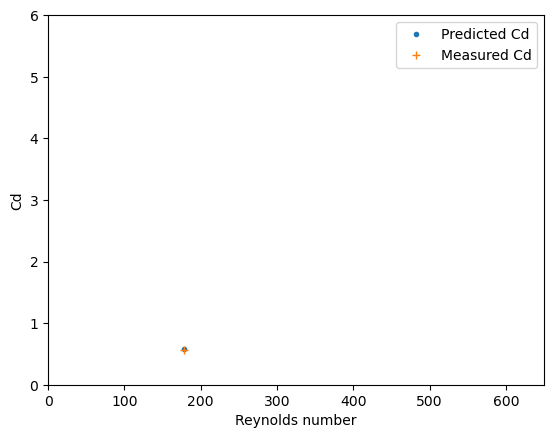

In [294]:
plt.plot(LH_cur['Re'][test_ids],Cd_acts,'.')
plt.plot(LH_cur['Re'][test_ids],Cd_actans,'+')
plt.xlabel('Reynolds number')
plt.ylabel('Cd')
plt.legend(['Predicted Cd','Measured Cd'])
plt.ylim([0,6])
plt.xlim([0,650])

Text(0.5, 1.0, 'Mass [kg]')

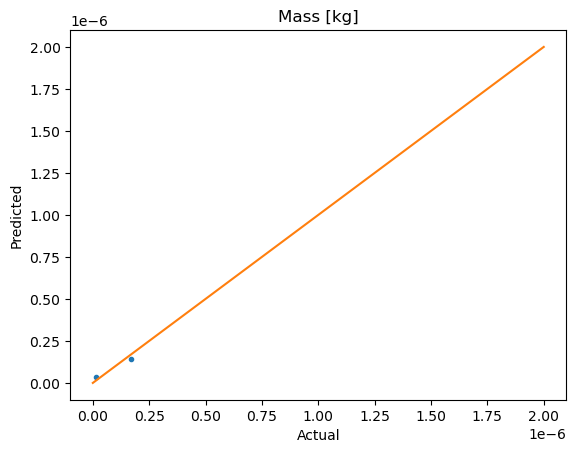

In [246]:
xa = np.array([0,0.000002])
ya = np.array([0,0.000002])
plt.plot(LH_cur['mass'][test_ids],mass_out,'.')
plt.plot(xa,ya)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Mass [kg]')

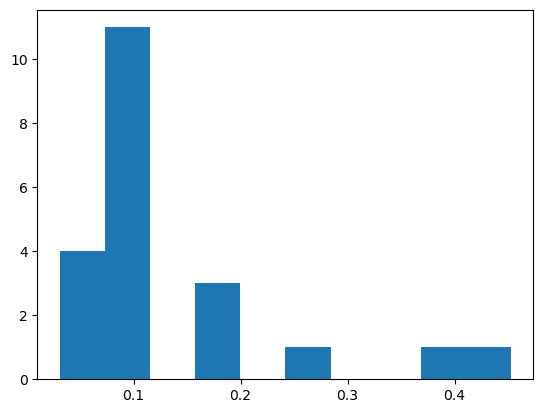

In [75]:
_=plt.hist(por_outs,bins=10)

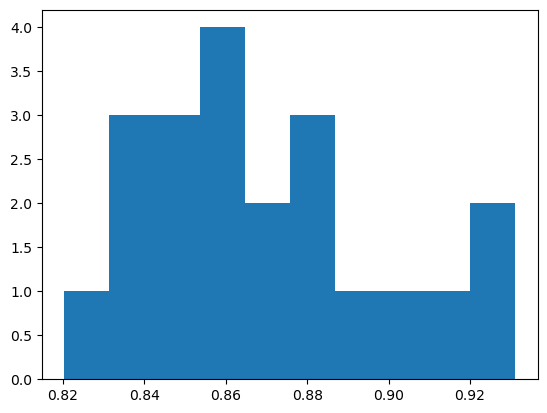

In [76]:
_=plt.hist(sph_outs,bins=10)

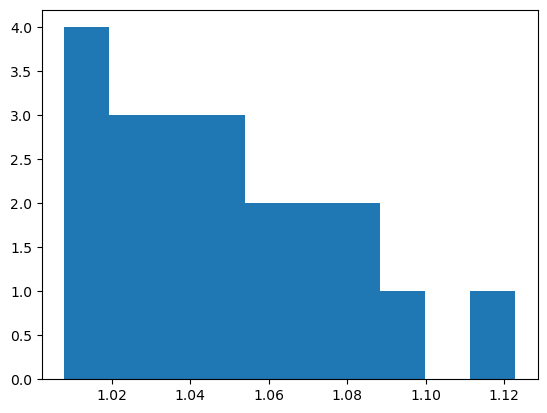

In [77]:
_=plt.hist(l_sph_outs,bins=10)

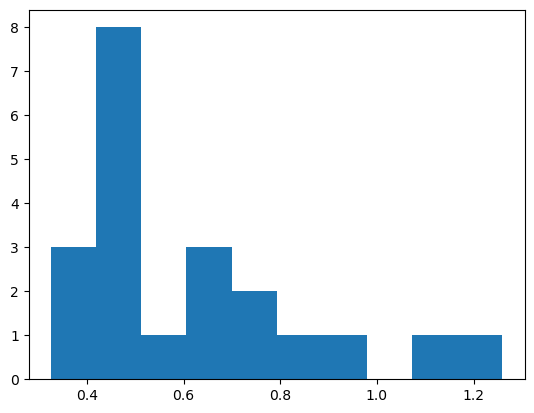

In [78]:
_=plt.hist(c_sph_outs,bins=10)

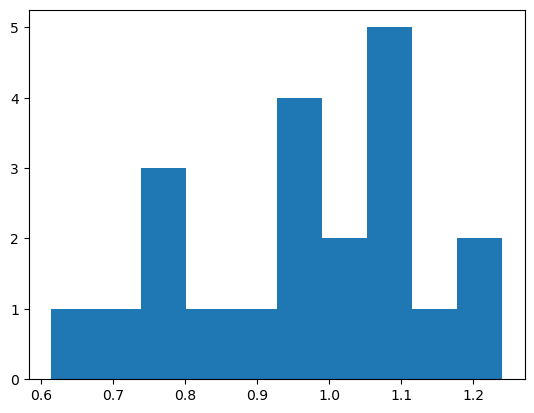

In [79]:
_=plt.hist(Acrat_outs,bins=10)

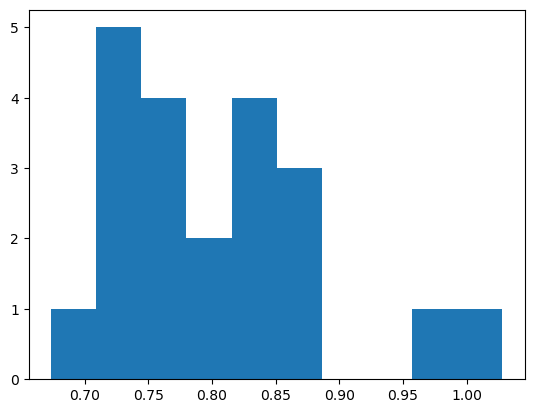

In [80]:
_=plt.hist(Alrat_outs,bins=10)